# Plot recreation
This notebook will run the code used to recreate the plots from the paper. There will be an option to either run the code to generate the required CSVs, or to only run the plotting code. The code to run the CSVs is expected to take multiple hours all together given an available GPU, so is not recommended to be ran on lower-end hardware.

In [21]:
## Packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Choose to run full experiments

To run the full experiments from the paper, set the variable CREATE_CSVS to True. Do be warned that this will likely take a lot of time, and require a lot of VRAM for the softmax experiments.

In [22]:
# Set to true to run the full scripts to generate the CSVs. This might take multiple hours, and is not recommended to be run without a GPU.
CREATE_CSVS = False


Runs all experiments if CREATE_CSVS is set.

Since the logit attribution experiment creates a lot of print statements, to reduce clutter in the notebook, the output will not be shown. The required CSV will still be made. If the outputs and tqdm time estimate is wanted, set SUPRESS_STDOUT_ATTRIBUTION to False.

Other experiments will still show their outputs and tqdm time estimate.

In [23]:
# Logit-attribution creates a ton of print statements to stdout. To remove clutter, stdout will be discarded when running these.
# If stdout is wanted, set to False.

if os.getcwd().split(os.sep)[-1] != "original_paper_code":
  os.chdir("original_paper_code")
SUPRESS_STDOUT_ATTRIBUTION = True
if CREATE_CSVS:
  os.chdir("Script")
  
  if SUPRESS_STDOUT_ATTRIBUTION:
    print("Running logit attribution (intermediate output is discarded to reduce clutter)")
    original_stdout = sys.stdout
    discard = open(os.devnull, 'w')
    sys.stdout = discard

  # Run logit attribution (seperate to discard stdout)
  !python run_all.py --logit-attribution

  # RUn softmax logit attribution
  !python run_all.py --logit-attribution --normalize-logit softmax --flag softmax --batch 5

  if SUPRESS_STDOUT_ATTRIBUTION:
    sys.stdout = original_stdout
    print("Logit attribution finished.")
    
  
  # Run rest of original experiments
  !python run_all.py --logit-lens --pattern --no-plot

  # Run rest of softmax logit experiments
  !python run_all.py --logit-lens --no-plot --normalize-logit softmax --flag softmax


  os.chdir("..")
  


In [24]:
## Loading in precomputed data sets
regular_dir = "results/copyVSfact"
softmax_dir = "results/copyVSfactsoftmax"
logit_attribution_dir = "/logit_attribution/gpt2_full/logit_attribution_data.csv"
logit_lens_dir = "/logit_lens/gpt2_full/logit_lens_data.csv"
head_pattern_dir = "/head_pattern/gpt2_full/head_pattern_data.csv"

logit_attribution_data = pd.read_csv(regular_dir + logit_attribution_dir)
logit_attribution_data_softmax = pd.read_csv(softmax_dir + logit_attribution_dir)
logit_lens_data = pd.read_csv(regular_dir + logit_lens_dir)
logit_lens_data_softmax = pd.read_csv(softmax_dir + logit_lens_dir)
head_pattern_data = pd.read_csv(regular_dir + head_pattern_dir)

fig_width, fig_height = 7,5
dpi = 600

In [25]:
## Functions for reproducing plots

def plot_intermediate_logits(data): # takes logit_lens_data

    # Extract the data for plotting
    data = data[data['position'] == 13]
    layers = data['layer']
    mem_values = data['mem']
    cp_values = data['cp']

    # Create the plot
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

    # Plot 'mem' values in blue with thicker lines
    plt.plot(layers, mem_values, label='Factual Token', marker='o', color='blue', linewidth=3)

    # Plot 'cp' values in red with thicker lines
    plt.plot(layers, cp_values, label='Counterfactual token', marker='o', color='red', linewidth=3)

    # Add labels and title
    plt.xlabel('Layer', fontsize=18)
    plt.ylabel('Logits in the Last Position', fontsize=18)

    # Set y-axis tick marks
    plt.yticks([0, 5, 10, 15])

    # Place the legend
    plt.legend(fontsize=12)

    # Adjust layout to add padding
    plt.tight_layout(pad=1.0)

    # Show the plot
    plt.show()

def plot_block_attribution_logits(data): # takes logit_attribution_data

    # Filter data where position == 13
    data = data[data['position'] == 13]

    # Extract ATT block data
    attn_out_data = data[data['label'].str.contains('attn_out')]
    att_diff = attn_out_data['cp_mean'] - attn_out_data['mem_mean']

    # Extract MLP block data
    mlp_out_data = data[data['label'].str.contains('mlp_out')]
    mlp_diff = mlp_out_data['cp_mean'] - mlp_out_data['mem_mean']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=600)

    # Define layers for plotting
    layers = [1,2,3,4,5,6,7,8,9,10,11,12]

    # Plot ATT block data
    axes[0].bar(layers, att_diff, color='orange', zorder=3)
    axes[0].set_xlabel('Layers')
    axes[0].set_ylabel(r'$\Delta_\text{cofa}$')
    axes[0].set_title('Attention Block')
    axes[0].tick_params(axis='x')

    # Plot MLP block data
    axes[1].bar(layers, mlp_diff, color='purple', zorder=3)
    axes[1].set_xlabel('Layers')
    #axes[1].set_ylabel(r'$\Delta t_\text{cofa}$')
    axes[1].set_title('MLP Block')
    axes[1].tick_params(axis='x')

    # Set x-axis to show layer values and scale y-axis
    for ax in axes:
        ax.set_xticks(range(len(layers)))
        ax.set_xticklabels(layers)
        ax.set_ylim([-1, 1.5])
        ax.set_yticks([i * 0.5 for i in range(-2, 4)])  # y-axis ticks separated by 0.5
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
        ax.grid(which='both', axis='y', linestyle='--', linewidth=0.5, zorder=0)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_head_attribution_logits(data): # takes logit_attribution_data

    # Filter data where position == 13
    data = data[data['position'] == 13]

    # Filter labels that start with "L"
    data = data[data['label'].str.startswith('L', na=False)]

    # Extract layer and head information
    data['layer'] = data['label'].apply(lambda x: int(x.split('H')[0][1:]))
    data['head'] = data['label'].apply(lambda x: int(x.split('H')[1]))

    # Compute difference
    data['diff'] = data['cp_mean'] - data['mem_mean']

    # Create a pivot table and transpose it
    pivot_table = data.pivot_table(values='diff', index='layer', columns='head').T

    # Plot the heatmap using seaborn
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = sns.heatmap(
        pivot_table,
        cmap='seismic',
        center=0,
        cbar=True,  # Enable colorbar
        cbar_kws={'orientation': 'vertical', 'shrink': 0.6, 'aspect': 10},
        linewidths=0.5,
        linecolor='grey',
        square=True,
        vmin=-1,
        vmax=1)

    # Reverse the y-axis
    plt.gca().invert_yaxis()

    # Adjust colorbar position and size
    cbar = ax.collections[0].colorbar
    cbar.ax.set_title(r'$\Delta_\text{cofa}$', fontsize=16, pad=10)
    cbar.ax.set_anchor((0.5, 0.5))  # Center the colorbar vertically

    # Customize the headers
    plt.xlabel('Layer', fontsize=16)
    plt.ylabel('Head', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_attention_per_token(data): #takes head_pattern_data

    # Define the specific (layer, head) pairs we are analyzing
    LayerHead = [(9,6), (9,9), (10,0), (10,7), (10,10), (11,10)]

    # Assuming head_pattern_data is already loaded
    data = head_pattern_data

    # Initialize an empty DataFrame to store the combined data
    combined_data = pd.DataFrame()

    # Loop through each (layer, head) pair and concatenate the filtered data
    for layer, head in LayerHead:
        # Ensure we're working with a copy to avoid SettingWithCopyWarning
        filtered_data = data[(data['layer'] == layer) &
                            (data['head'] == head) &
                            (data['source_position'] == 13)].copy()

        # Assign 'layer_head' column safely
        filtered_data.loc[:, 'layer_head'] = f'Layer {layer} | Head {head}'

        # Change the sign for specific (layer, head) pairs
        if (layer, head) in [(10,7), (11,10)]:
            filtered_data.loc[:, 'value'] = -filtered_data['value']

        # Append the modified data
        combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)

    # Set the order of the 'layer_head' category in reverse order
    combined_data['layer_head'] = pd.Categorical(
        combined_data['layer_head'],
        categories=[f'Layer {layer} | Head {head}' for layer, head in reversed(LayerHead)],
        ordered=True
    )

    # Pivot the table to get the destination positions as columns
    pivot_table_combined = combined_data.pivot(index='layer_head', columns='dest_position', values='value')

    # Set a fixed color range for the heatmap to avoid extreme dark colors
    vmin, vmax = -1, 1

    # Create the main heatmap with fixed color limits
    plt.figure(figsize=(2*fig_width, fig_height), dpi=dpi)
    ax = sns.heatmap(
        pivot_table_combined,
        cmap='seismic',  # Use diverging colormap for heatmap
        center=0,  # Center the colormap at 0
        cbar=False,  # Disable the default color bar
        linewidths=0.1,
        linecolor='grey',
        square=True,
        vmin=vmin,  # Set minimum color value
        vmax=vmax    # Set maximum color value
    )

    # Set the x-axis label
    plt.xlabel('Token Position', fontsize=12)

    # Create a divider for the axes
    divider = make_axes_locatable(ax)

    # Add the first color bar (negative values - blue)
    cax_neg = divider.append_axes("right", size="5%", pad=0.1)

    # Set the label at the top with a multi-line format
    cax_neg.set_title("Factual\nAttention", loc='left', fontsize=10)

    # Add the second color bar (positive values - red)
    cax_pos = divider.append_axes("right", size="5%", pad=0.8)

    # Set the label at the top with a multi-line format
    cax_pos.set_title("Counterfactual\nAttention", loc='left', fontsize=10)

    # Remove y-axis label explicitly
    ax.set_ylabel('')
    ax.yaxis.set_label_coords(-0.1, 0.5)  # Adjusts space to ensure full removal

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [26]:
## Functions for new plots

def plot_intermediate_logits_softmax(data): # takes logit_lens_data

    # Extract the data for plotting
    data = data[data['position'] == 13]
    layers = data['layer']
    mem_values = data['mem']
    cp_values = data['cp']

    # Create the plot
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

    # Plot 'mem' values in blue with thicker lines
    plt.plot(layers, mem_values, label='Factual Token', marker='o', color='blue', linewidth=3)

    # Plot 'cp' values in red with thicker lines
    plt.plot(layers, cp_values, label='Counterfactual token', marker='o', color='red', linewidth=3)

    # Add labels and title
    plt.xlabel('Layer', fontsize=18)
    plt.ylabel('Probabilities in the Last Position', fontsize=18)

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Place the legend underneath the plot area but inside the figure
    plt.legend(fontsize=12)

    # Adjust layout to add padding
    plt.tight_layout(pad=1.0)

    # Show the plot
    plt.show()

def plot_block_attribution_logits_softmax(data): # takes logit_attribution_data

    # Filter data where position == 13
    data = data[data['position'] == 13]

    # Extract ATT block data
    attn_out_data = data[data['label'].str.contains('attn_out')]
    att_diff = attn_out_data['cp_mean'] - attn_out_data['mem_mean']

    # Extract MLP block data
    mlp_out_data = data[data['label'].str.contains('mlp_out')]
    mlp_diff = mlp_out_data['cp_mean'] - mlp_out_data['mem_mean']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*fig_width, fig_height), dpi=dpi)

    # Define layers for plotting
    layers = [1,2,3,4,5,6,7,8,9,10,11,12]

    # Plot ATT block data
    axes[0].bar(layers, att_diff, color='orange', zorder=3)
    axes[0].set_xlabel('Layers')
    axes[0].set_ylabel(r'$\widetilde\Delta_\text{cofa}$')
    axes[0].set_title('Attention Block')
    axes[0].tick_params(axis='x')

    # Plot MLP block data
    axes[1].bar(layers, mlp_diff, color='purple', zorder=3)
    axes[1].set_xlabel('Layers')
    axes[1].set_title('MLP Block')
    axes[1].tick_params(axis='x')

    # Set x-axis to show layer values and scale y-axis
    for ax in axes:
        ax.set_xticks(range(len(layers)))
        ax.set_xticklabels(layers)
        ax.set_ylim(-1e-4, 6e-4)
        ax.set_yticks(np.arange(-1e-4, 6.5e-4, 1e-4))
        ax.yaxis.set_major_locator(plt.MultipleLocator(1e-4))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(5e-5))
        ax.grid(which='both', axis='y', linestyle='--', linewidth=0.5, zorder=0)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_block_attribution_logits_softmax_merged(data):  # Takes logit_attribution_data_softmax

    # Filter data where position == 13
    data = data[data['position'] == 13].copy()

    # Filter data for attn_out and mlp_out
    attn_out_data = data[data['label'].str.contains('attn_out', na=False)].copy()
    mlp_out_data = data[data['label'].str.contains('mlp_out', na=False)].copy()

    # Extract layer numbers from labels safely
    attn_out_data.loc[:, 'layer'] = pd.to_numeric(attn_out_data['label'].str.extract(r'(\d+)')[0], errors='coerce')
    mlp_out_data.loc[:, 'layer'] = pd.to_numeric(mlp_out_data['label'].str.extract(r'(\d+)')[0], errors='coerce')

    # Drop NaN values before converting to int
    attn_out_data = attn_out_data.dropna(subset=['layer'])
    mlp_out_data = mlp_out_data.dropna(subset=['layer'])

    # Convert to integer after handling NaNs
    attn_out_data.loc[:, 'layer'] = attn_out_data['layer'].astype(int)
    mlp_out_data.loc[:, 'layer'] = mlp_out_data['layer'].astype(int)

    # Sort data by layer
    attn_out_data = attn_out_data.sort_values('layer')
    mlp_out_data = mlp_out_data.sort_values('layer')

    # Create a combined dataframe
    combined_data = pd.merge(attn_out_data, mlp_out_data, on='layer', suffixes=('_attn', '_mlp'))

    # Create the plot
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    bar_width = 0.45
    index = combined_data['layer']

    # Plot attn_out and mlp_out data side by side
    bar1 = ax.bar(index - bar_width/2, combined_data['cp_mean_attn'] - combined_data['mem_mean_attn'], bar_width, label='Attention Block', color='orange', zorder=3)
    bar2 = ax.bar(index + bar_width/2, combined_data['cp_mean_mlp'] - combined_data['mem_mean_mlp'], bar_width, label='MLP Block', color='purple', zorder=3)

    # Set labels and title
    ax.set_xlabel('Layers')
    ax.set_ylabel(r'$\widetilde\Delta_\text{cofa}$')
    ax.set_title('Attention Block vs MLP Block')
    ax.set_xticks(index)
    ax.set_xticklabels(index)
    ax.set_ylim([-0.00015, .0006])
    ax.grid(which='both', axis='y', linestyle='--', linewidth=0.5, zorder=0)

    # Add legend
    ax.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_head_attribution_logits_softmax(data): # takes logit_attribution_data

    # Filter data where position == 13
    data = data[data['position'] == 13]

    # Filter labels that start with "L"
    data = data[data['label'].str.startswith('L', na=False)]

    # Extract layer and head information
    data['layer'] = data['label'].apply(lambda x: int(x.split('H')[0][1:]))
    data['head'] = data['label'].apply(lambda x: int(x.split('H')[1]))

    # Compute difference
    data['diff'] = data['cp_mean'] - data['mem_mean']

    # Create a pivot table and transpose it
    pivot_table = data.pivot_table(values='diff', index='layer', columns='head').T

    # Determine the limits for the color scale
    vmax = max(abs(pivot_table.min().min()), abs(pivot_table.max().max()))

    # Plot the heatmap using seaborn
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = sns.heatmap(
        pivot_table,
        cmap='seismic',
        center=0,
        cbar = True,
        cbar_kws={'orientation': 'vertical', 'shrink': 0.6, 'aspect': 10},
        linewidths=0.5,
        linecolor='grey',
        square=True,
        vmin=-vmax,
        vmax=vmax)

    # Reverse the y-axis
    plt.gca().invert_yaxis()

    # Adjust colorbar position and size
    cbar = ax.collections[0].colorbar
    cbar.ax.set_title(r'$\widetilde\Delta_\text{cofa}$', fontsize=16, pad=10)
    cbar.ax.set_anchor((0.5, 0.5))  # Center the colorbar vertically

    # Customize the headers
    plt.xlabel('Layer', fontsize=16)
    plt.ylabel('Head', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# We start with the plots of the original paper

The first set of plots are from the replication study, where both the code and plotting strategy are replicated from Ortu et al. (2024). We mention the original Section and Figure ID, then show our own corresponding reproduction resutls.

## Section 6.1 Figure 2b

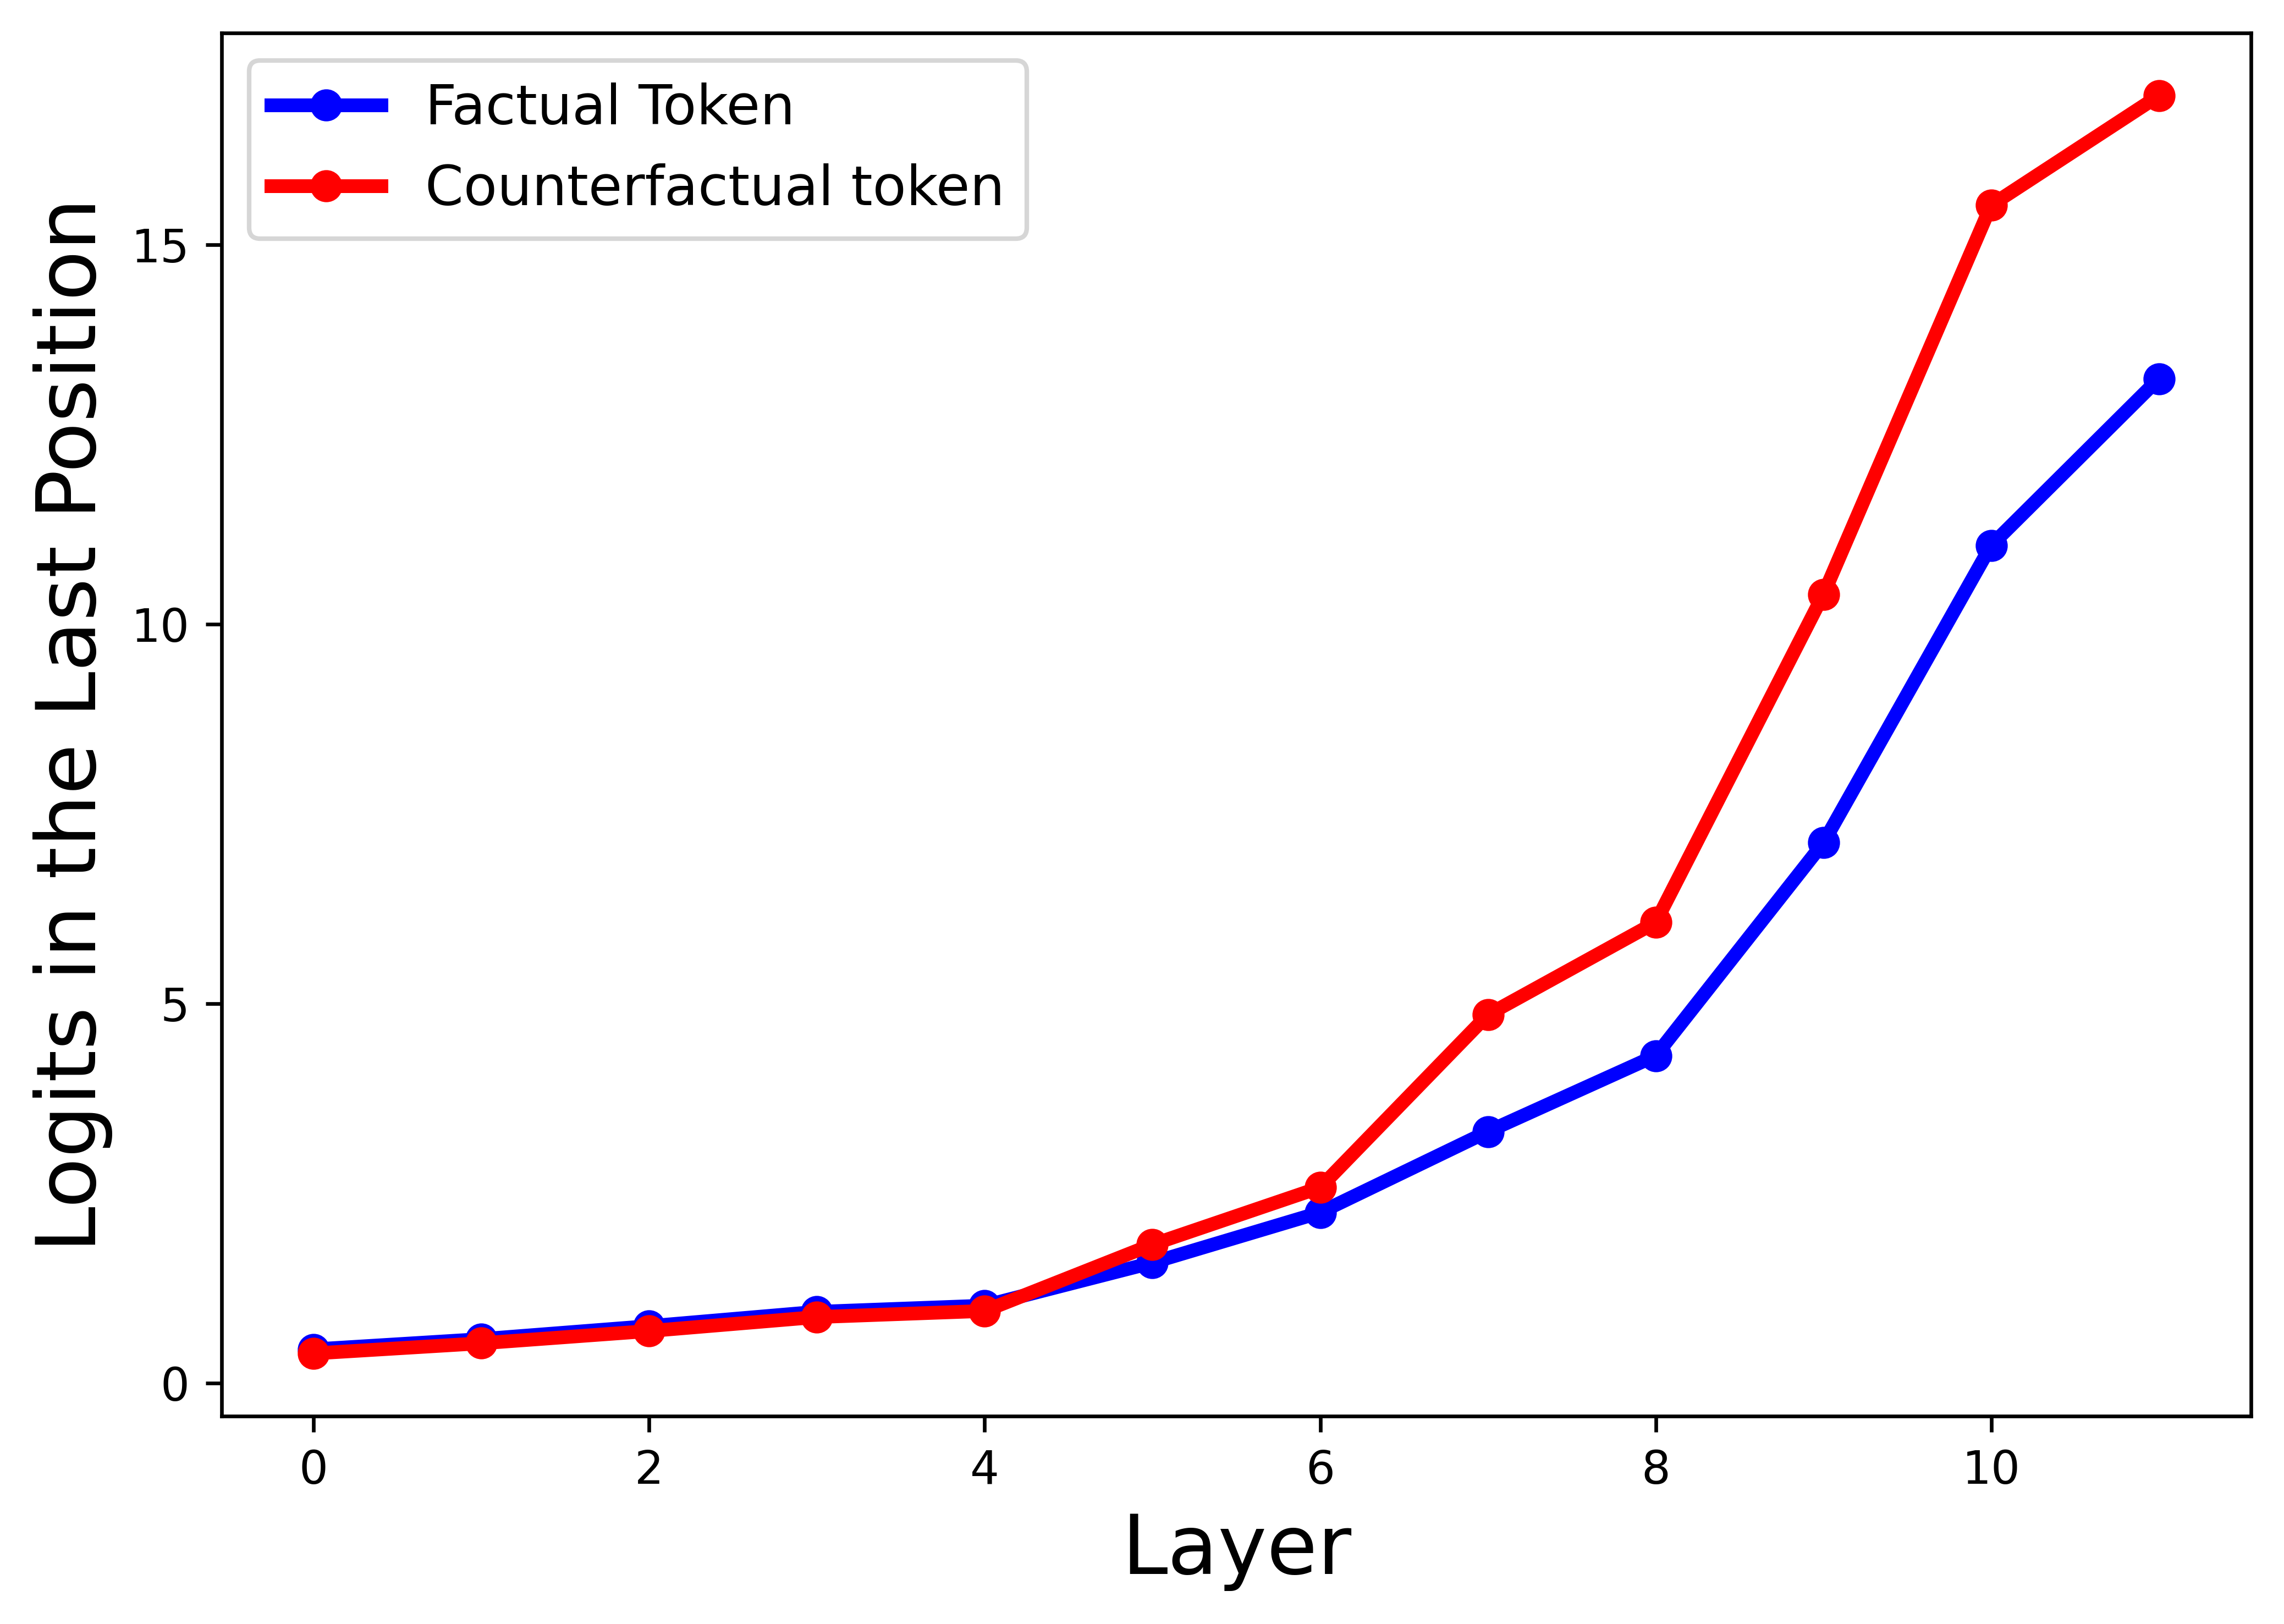

In [27]:
plot_intermediate_logits(logit_lens_data)

## Section 6.2 Figure 3


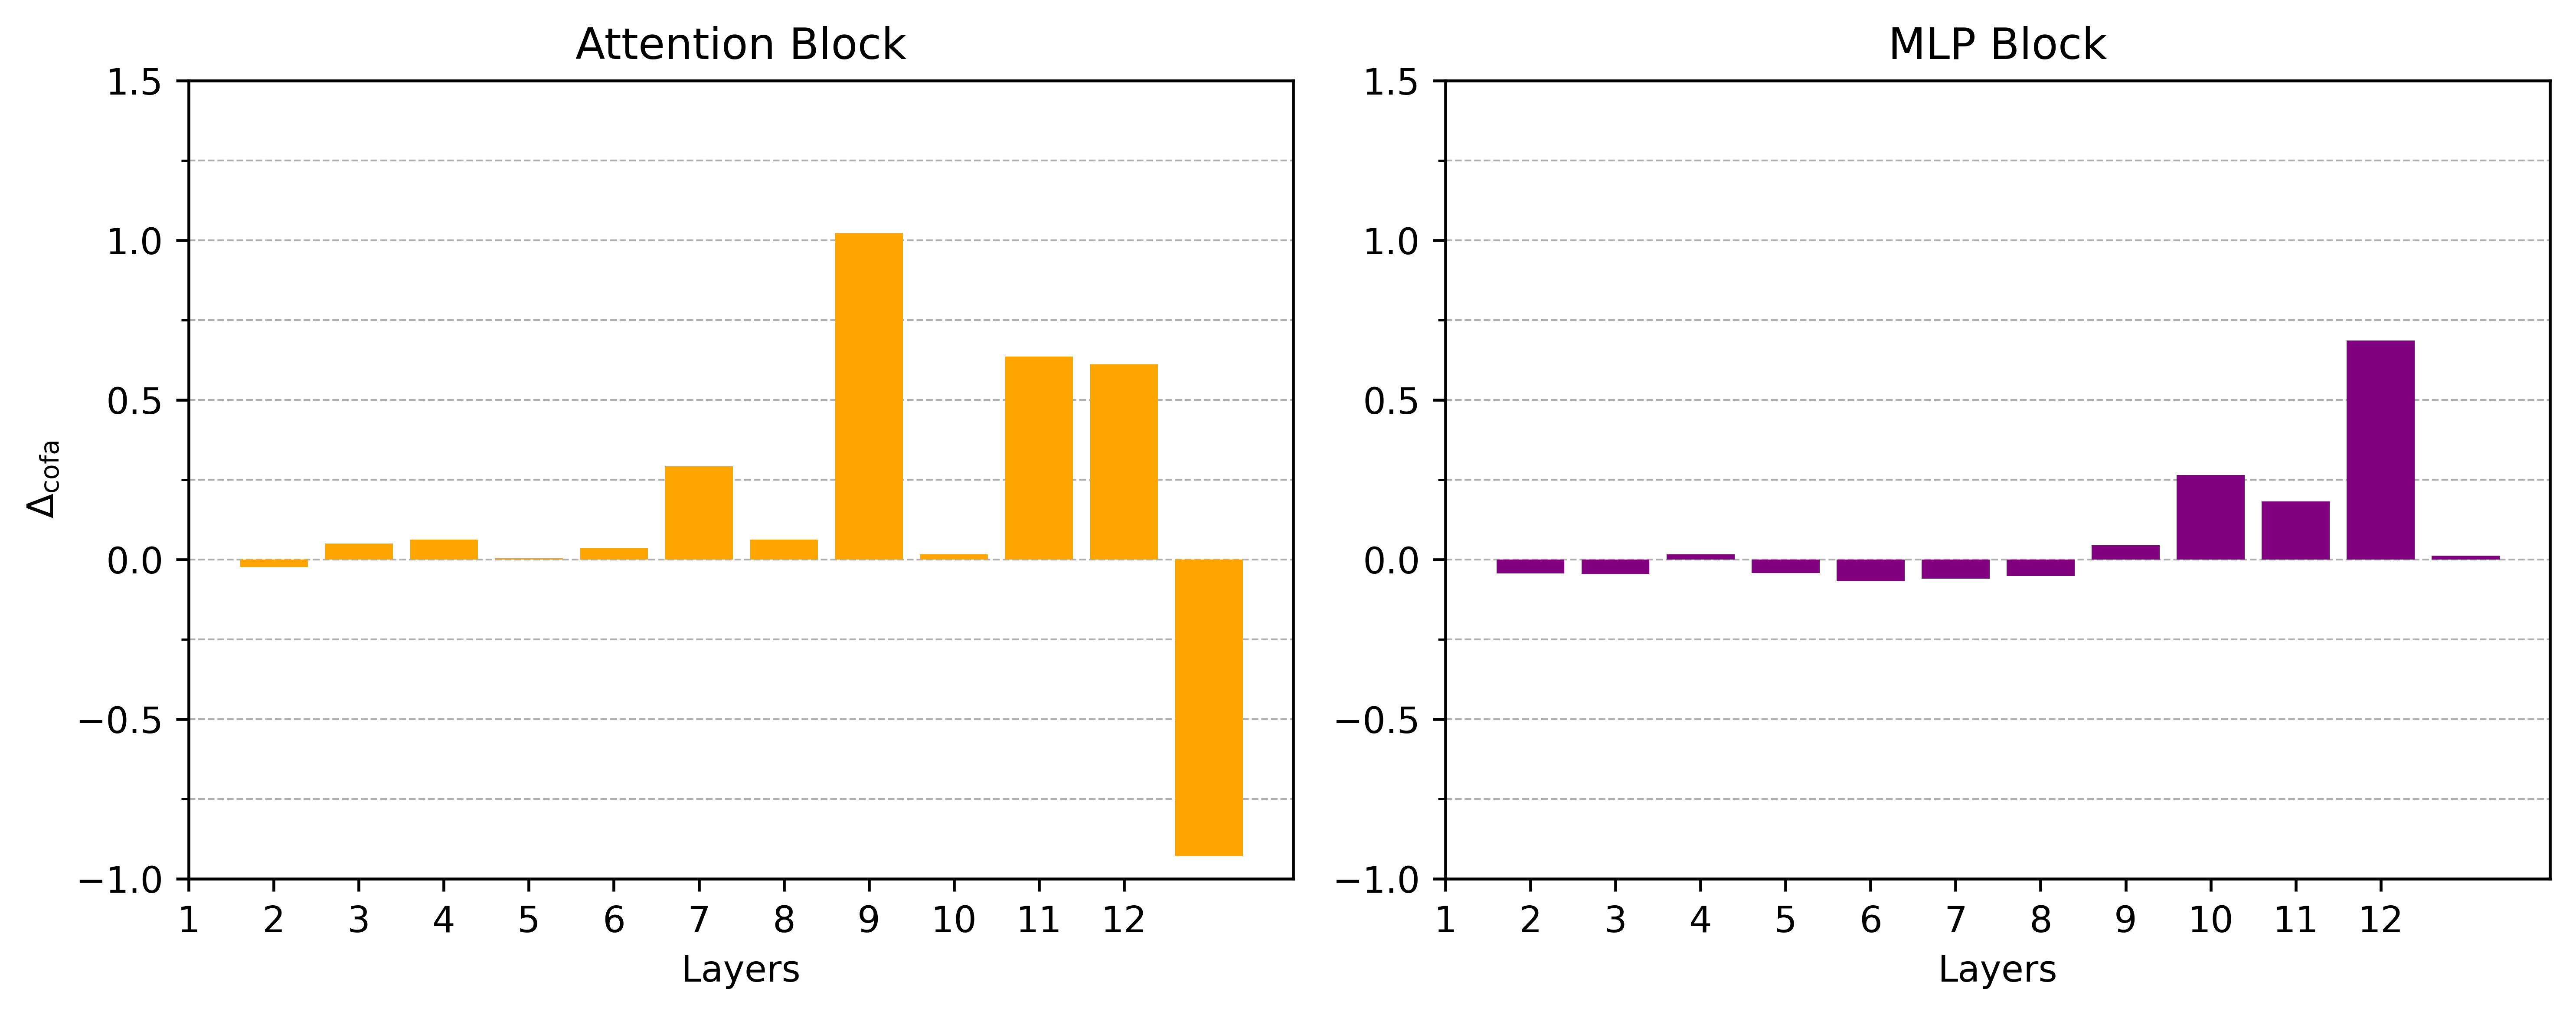

In [28]:
plot_block_attribution_logits(logit_attribution_data)

## Section 6.3 Figure 4a

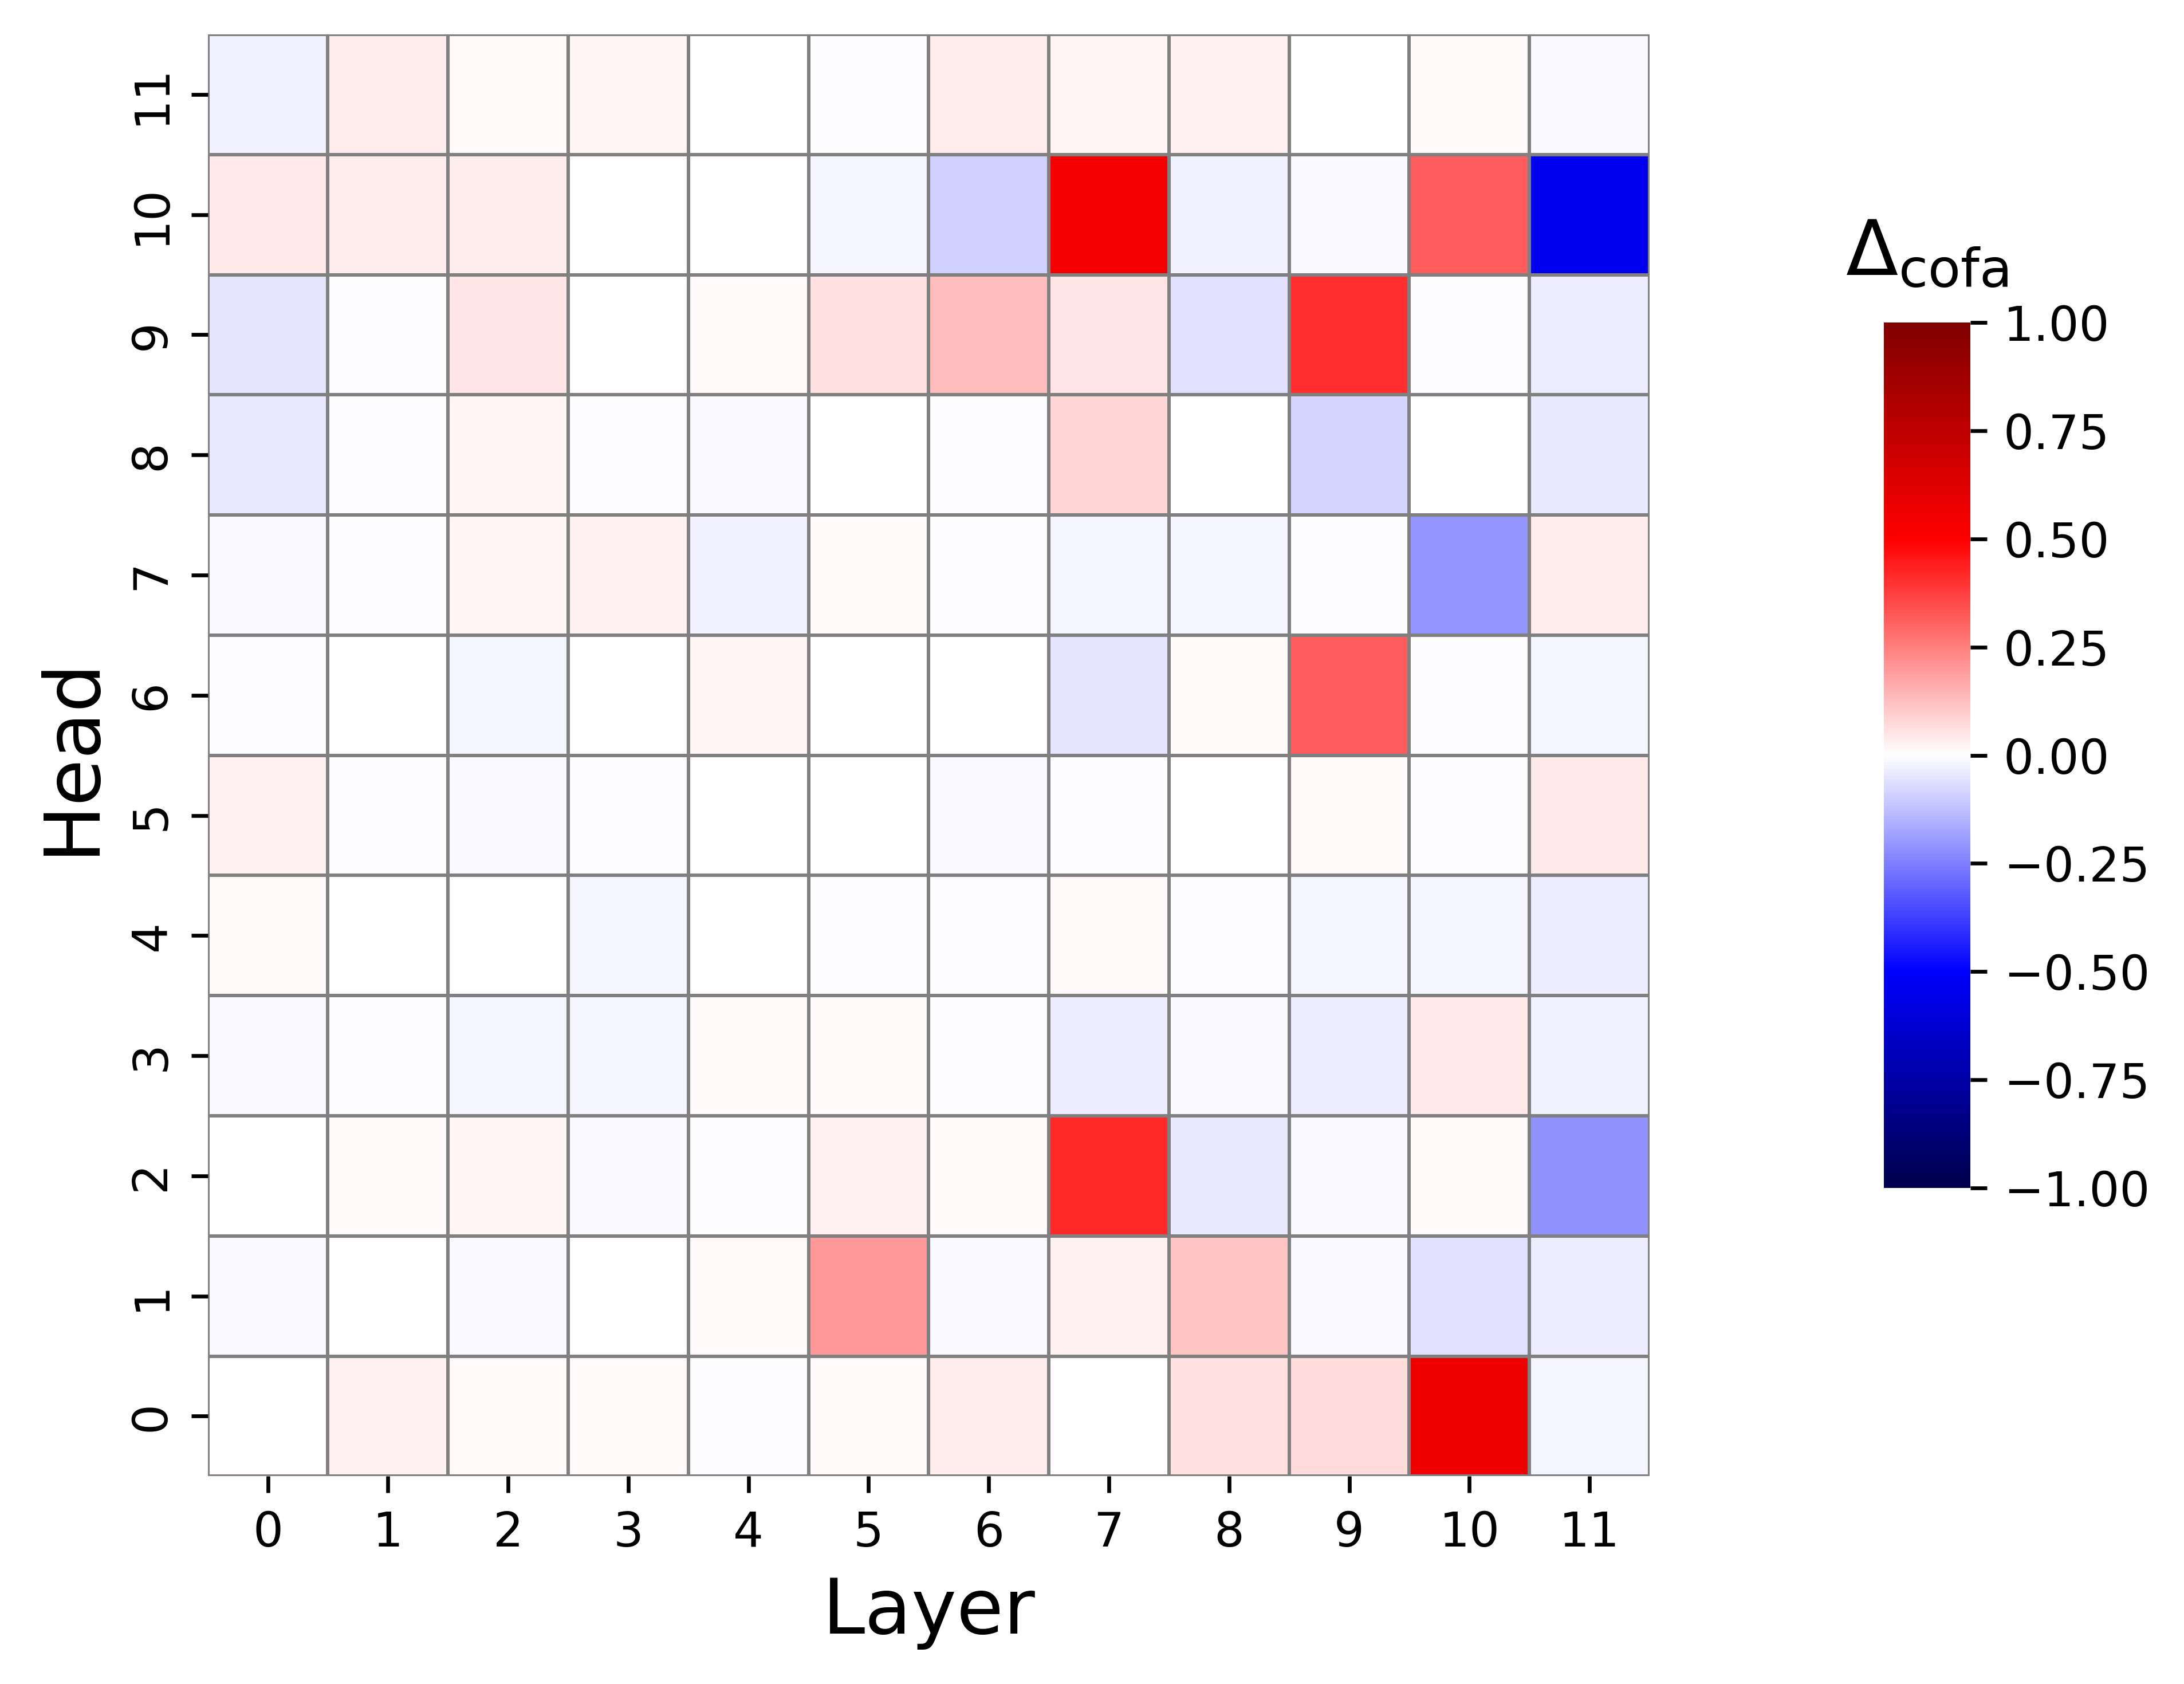

In [29]:
plot_head_attribution_logits(logit_attribution_data)

## Section 6.3 Figure 4b

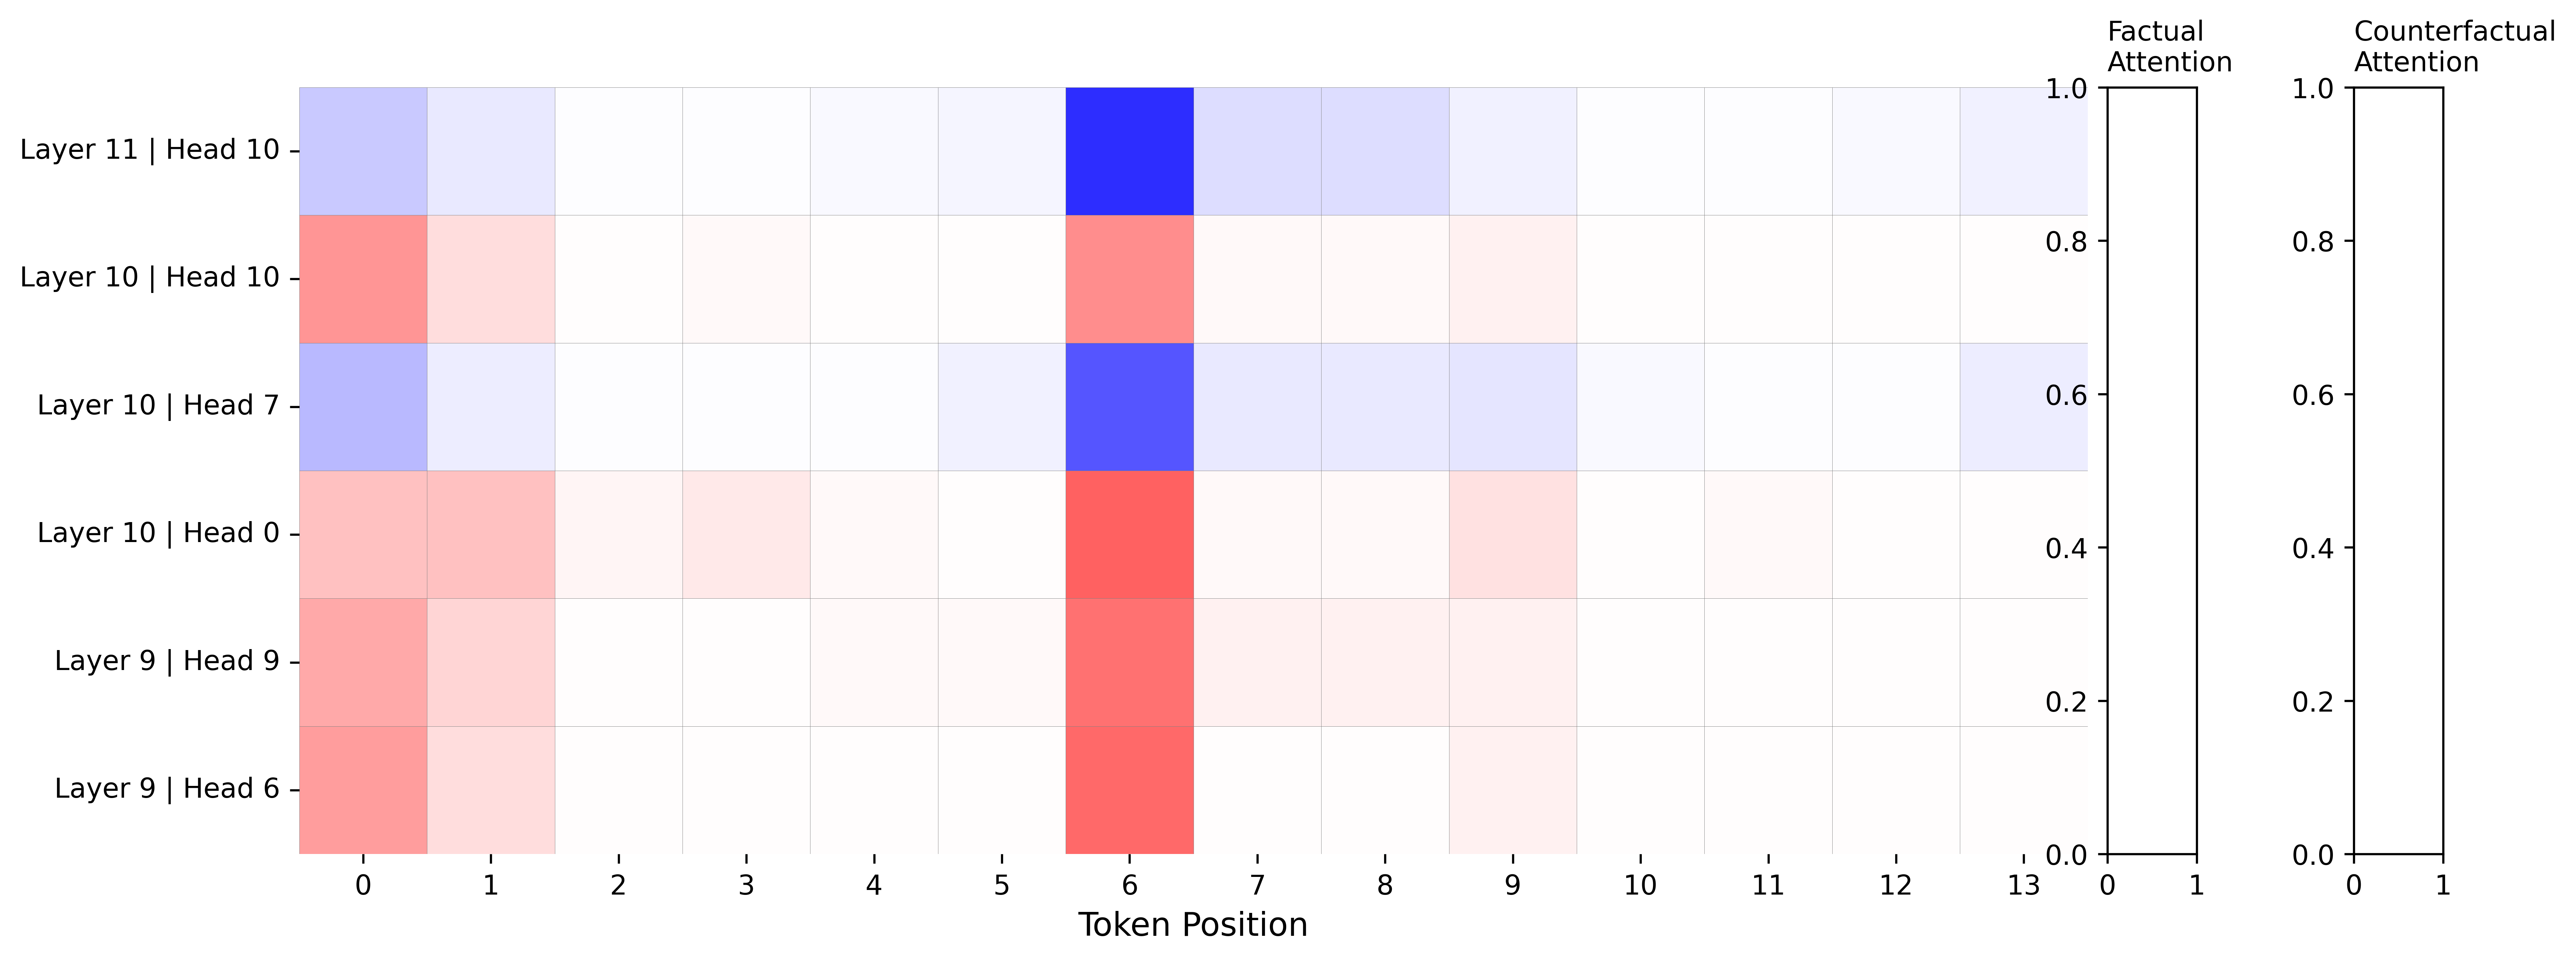

In [30]:
plot_attention_per_token(head_pattern_data)

# Further experiments

Now we give the plots of the extended experiments, starting with softmax experiments.

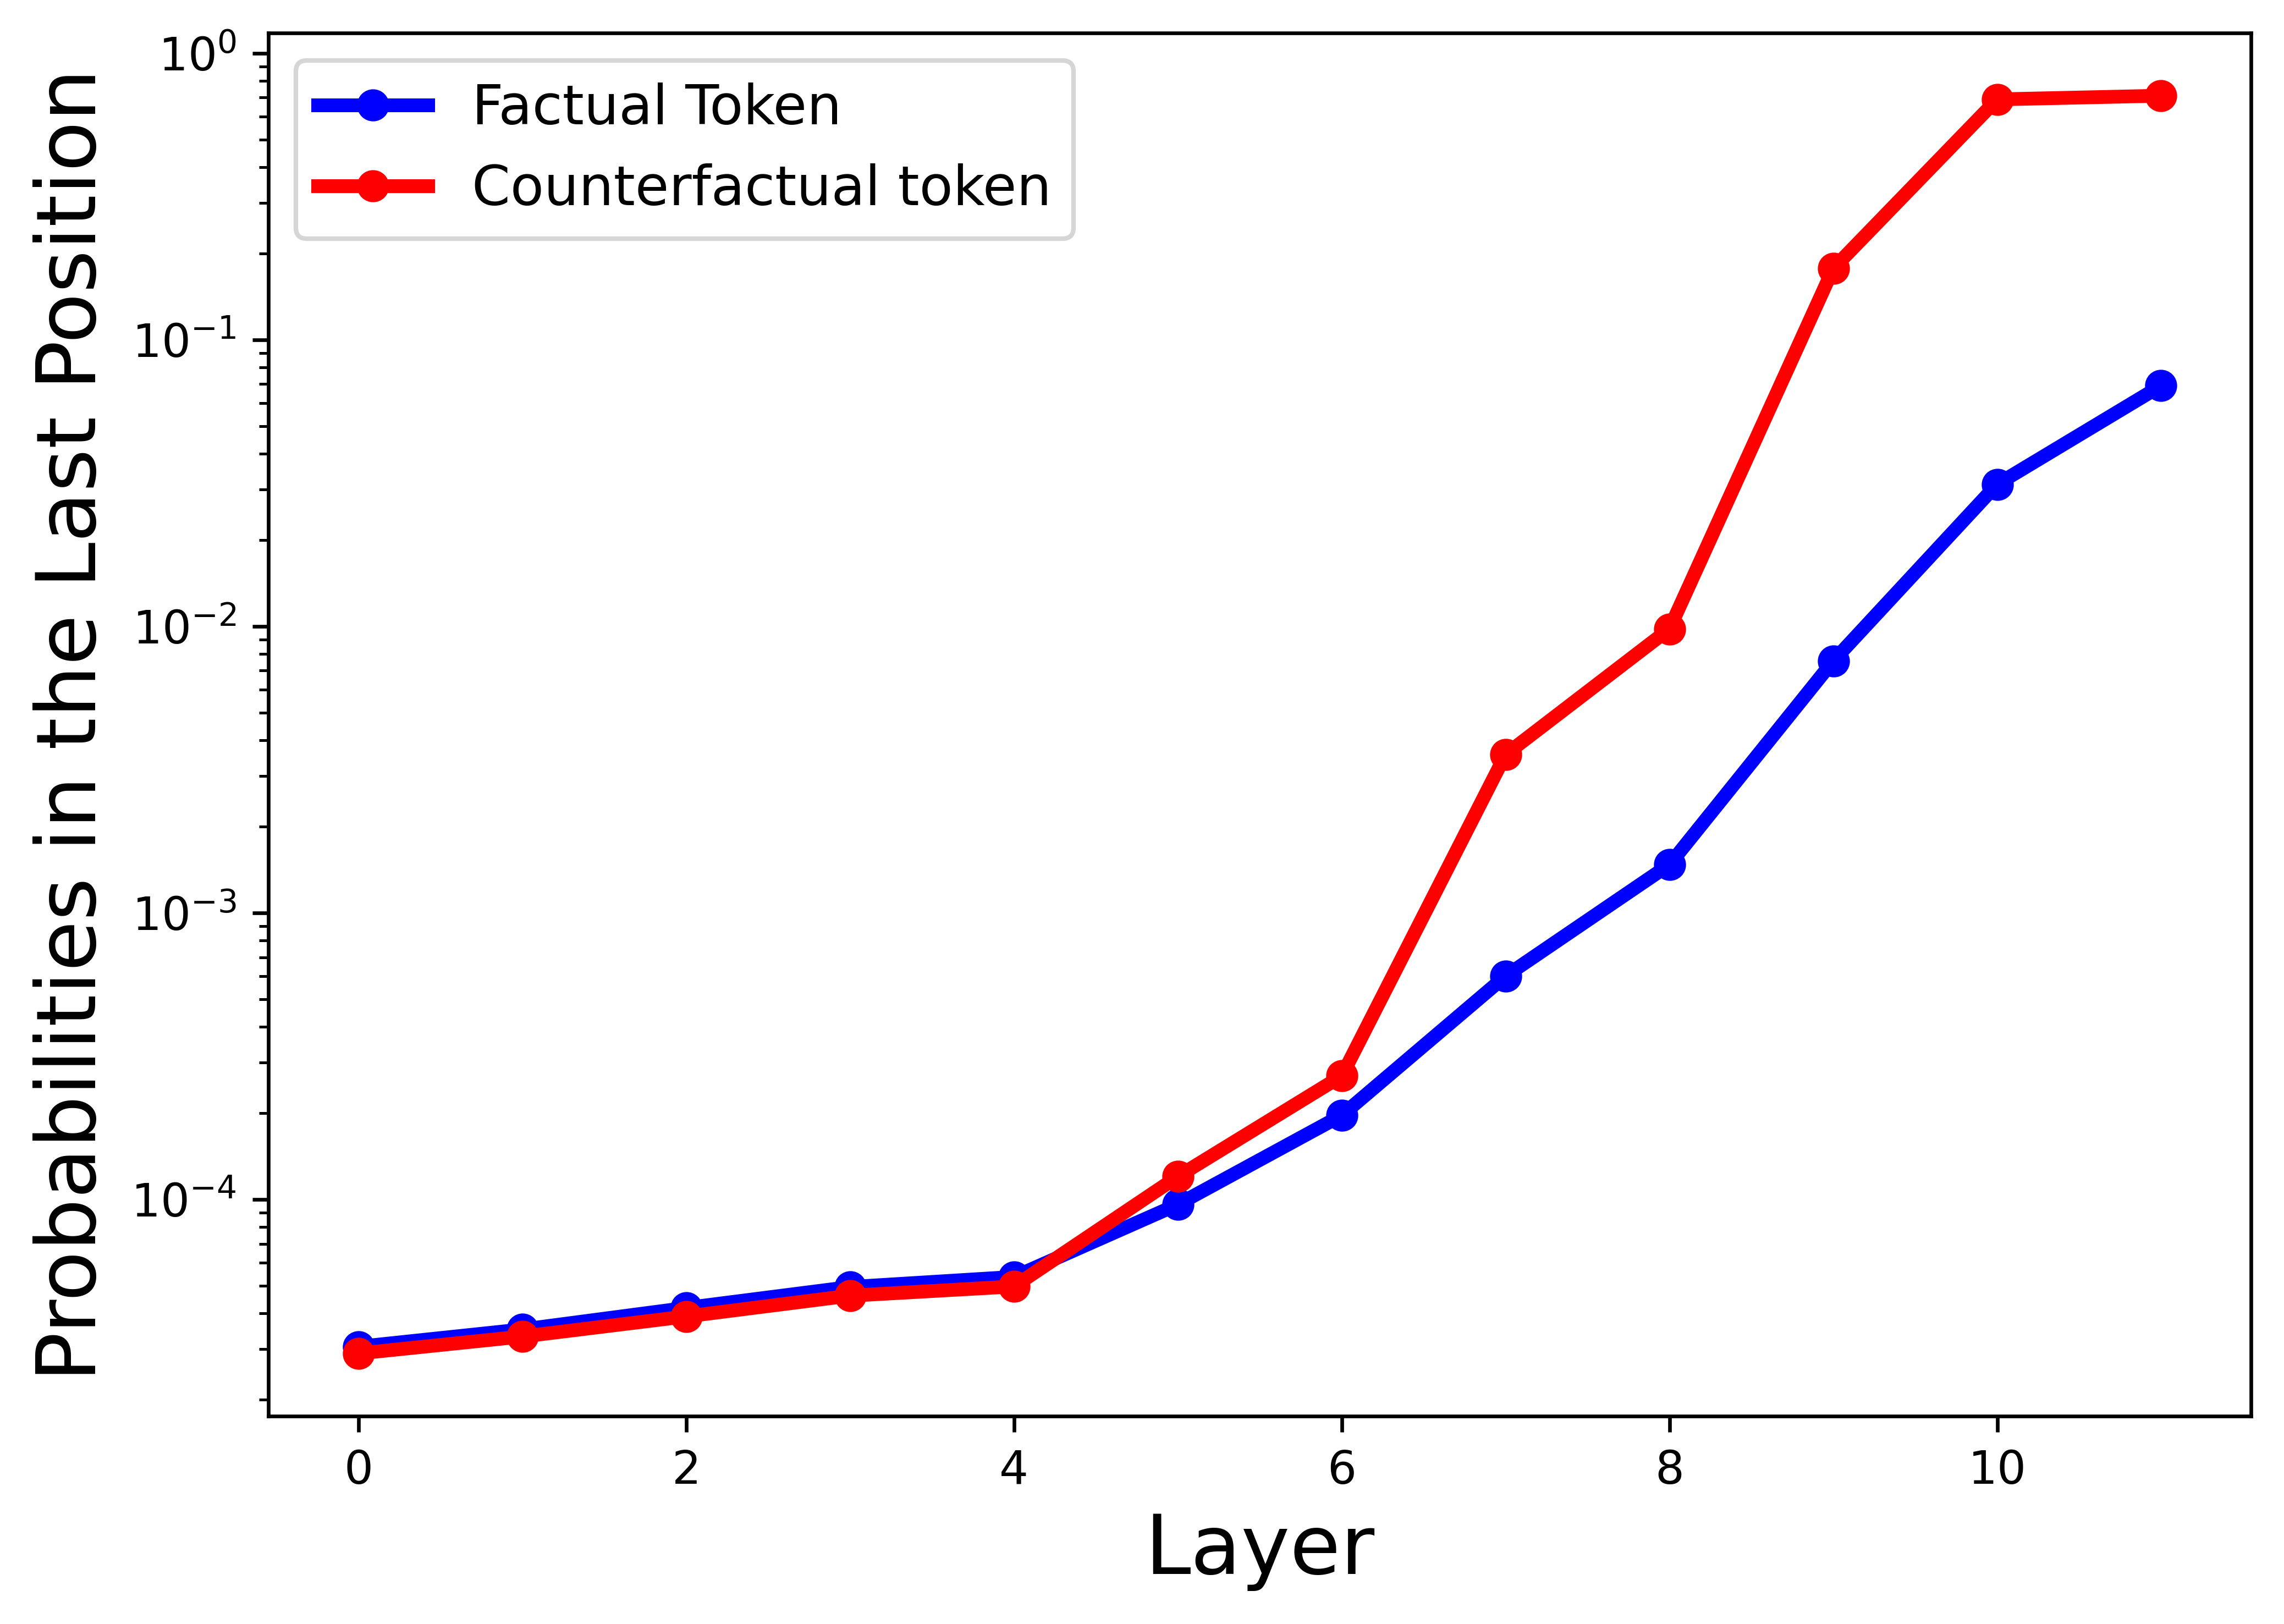

In [31]:
plot_intermediate_logits_softmax(logit_lens_data_softmax)

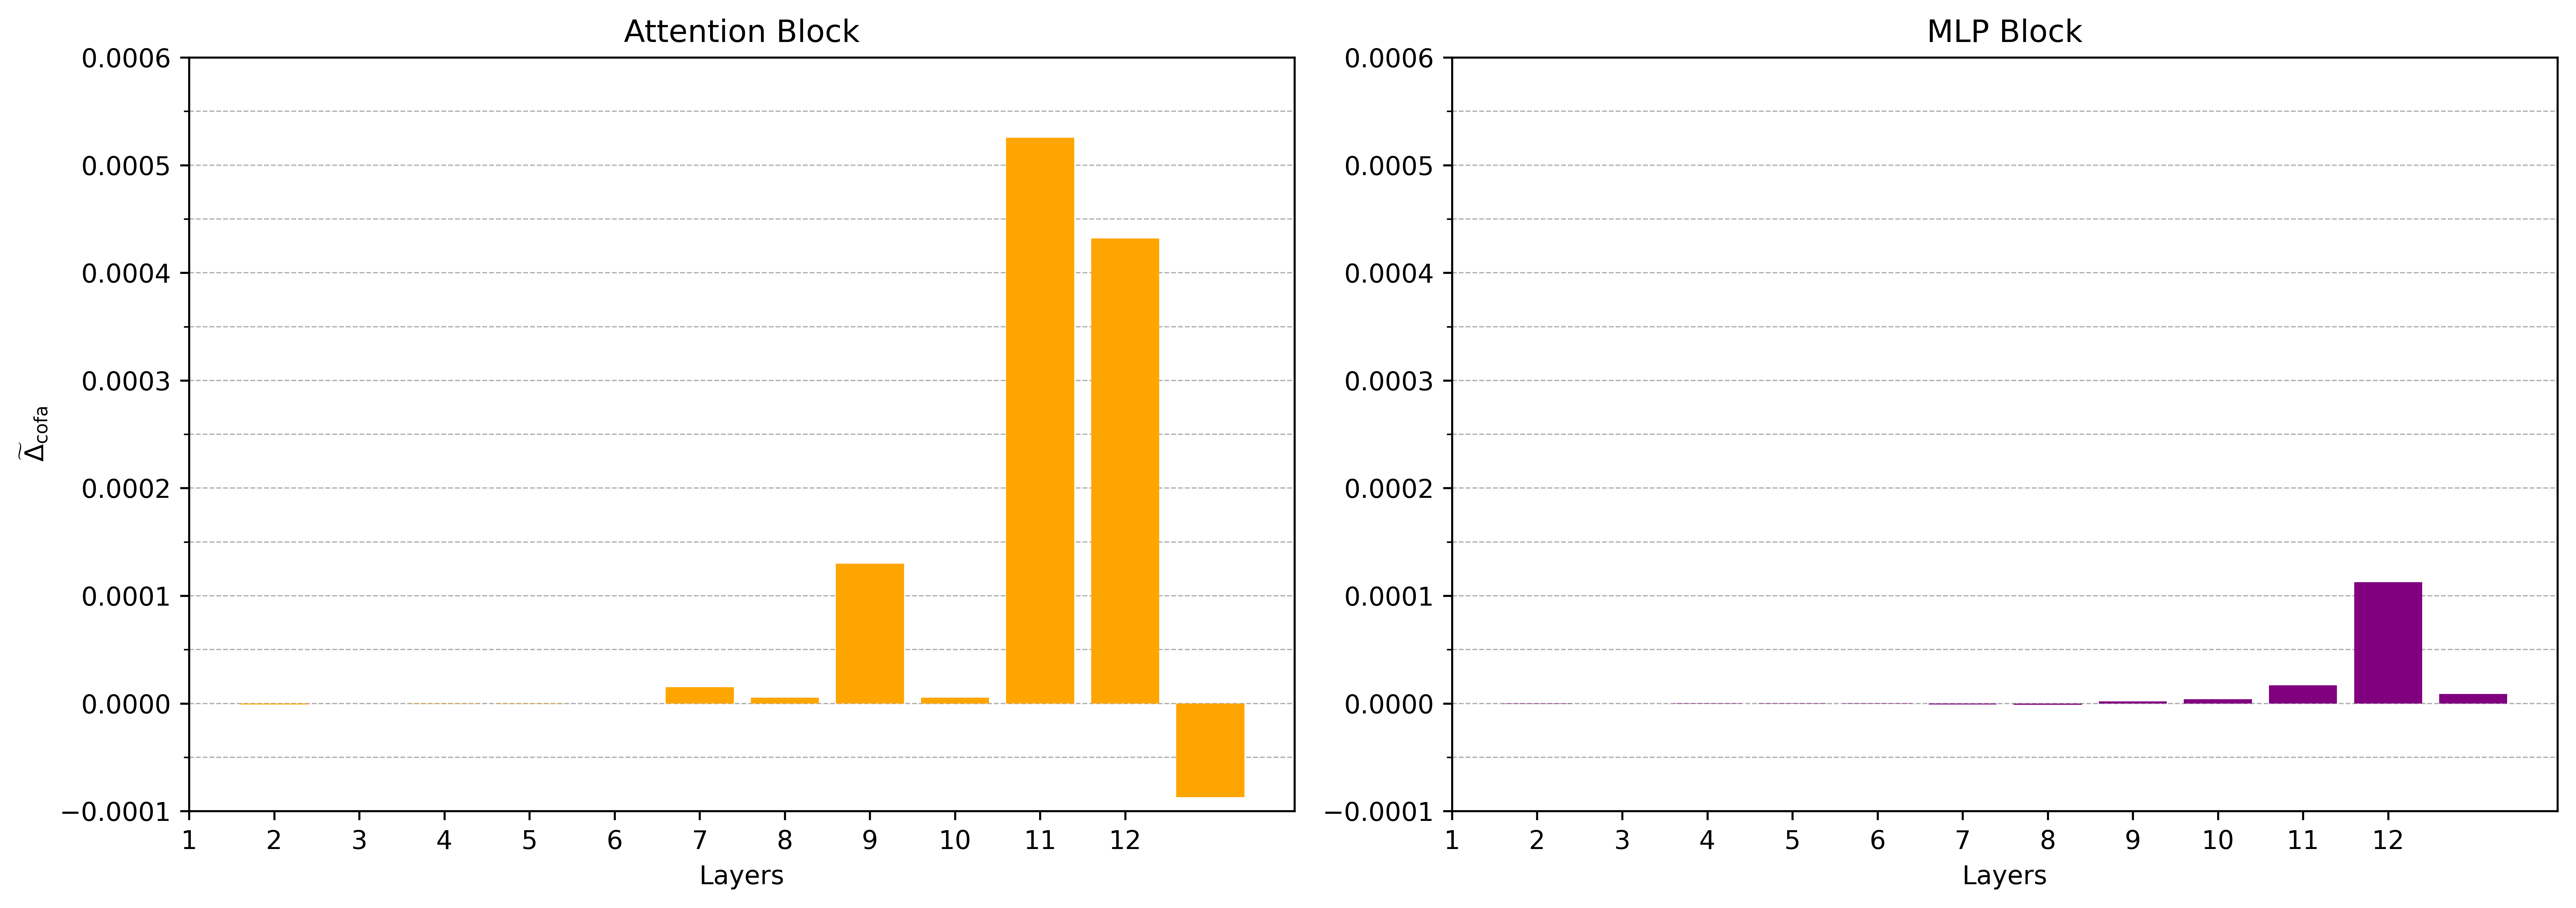

In [32]:
plot_block_attribution_logits_softmax(logit_attribution_data_softmax)

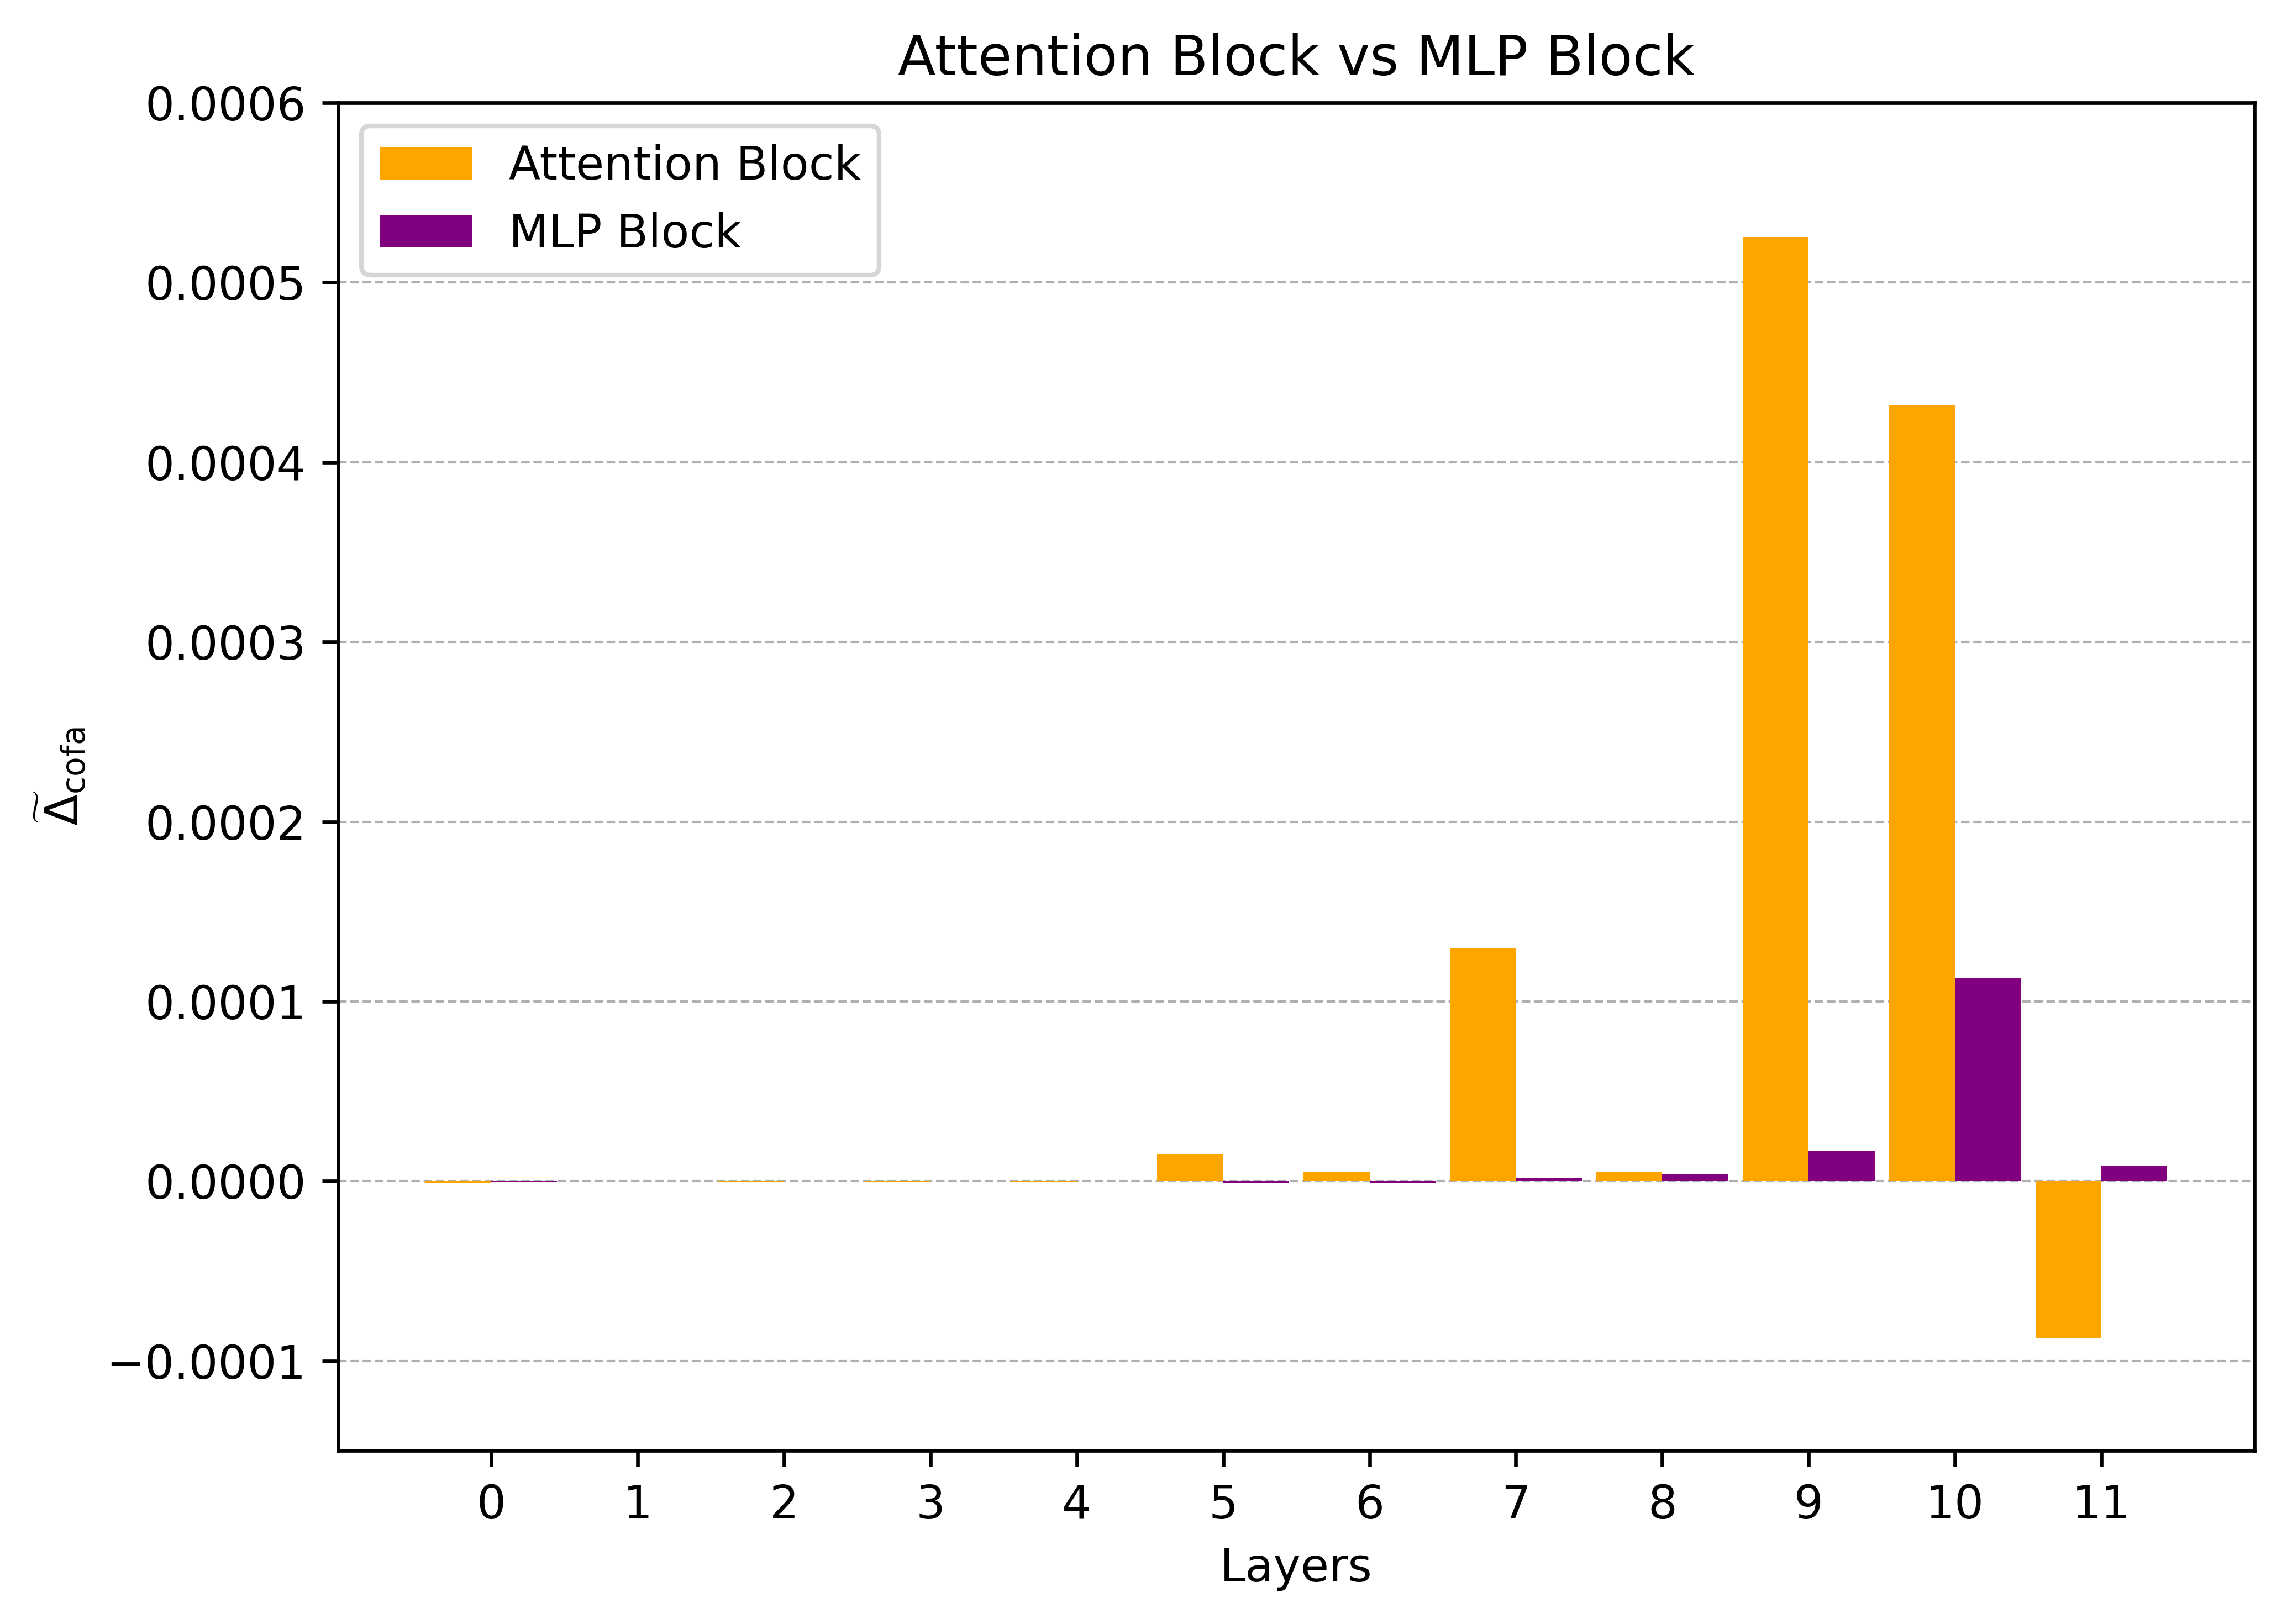

In [33]:
plot_block_attribution_logits_softmax_merged(logit_attribution_data_softmax)

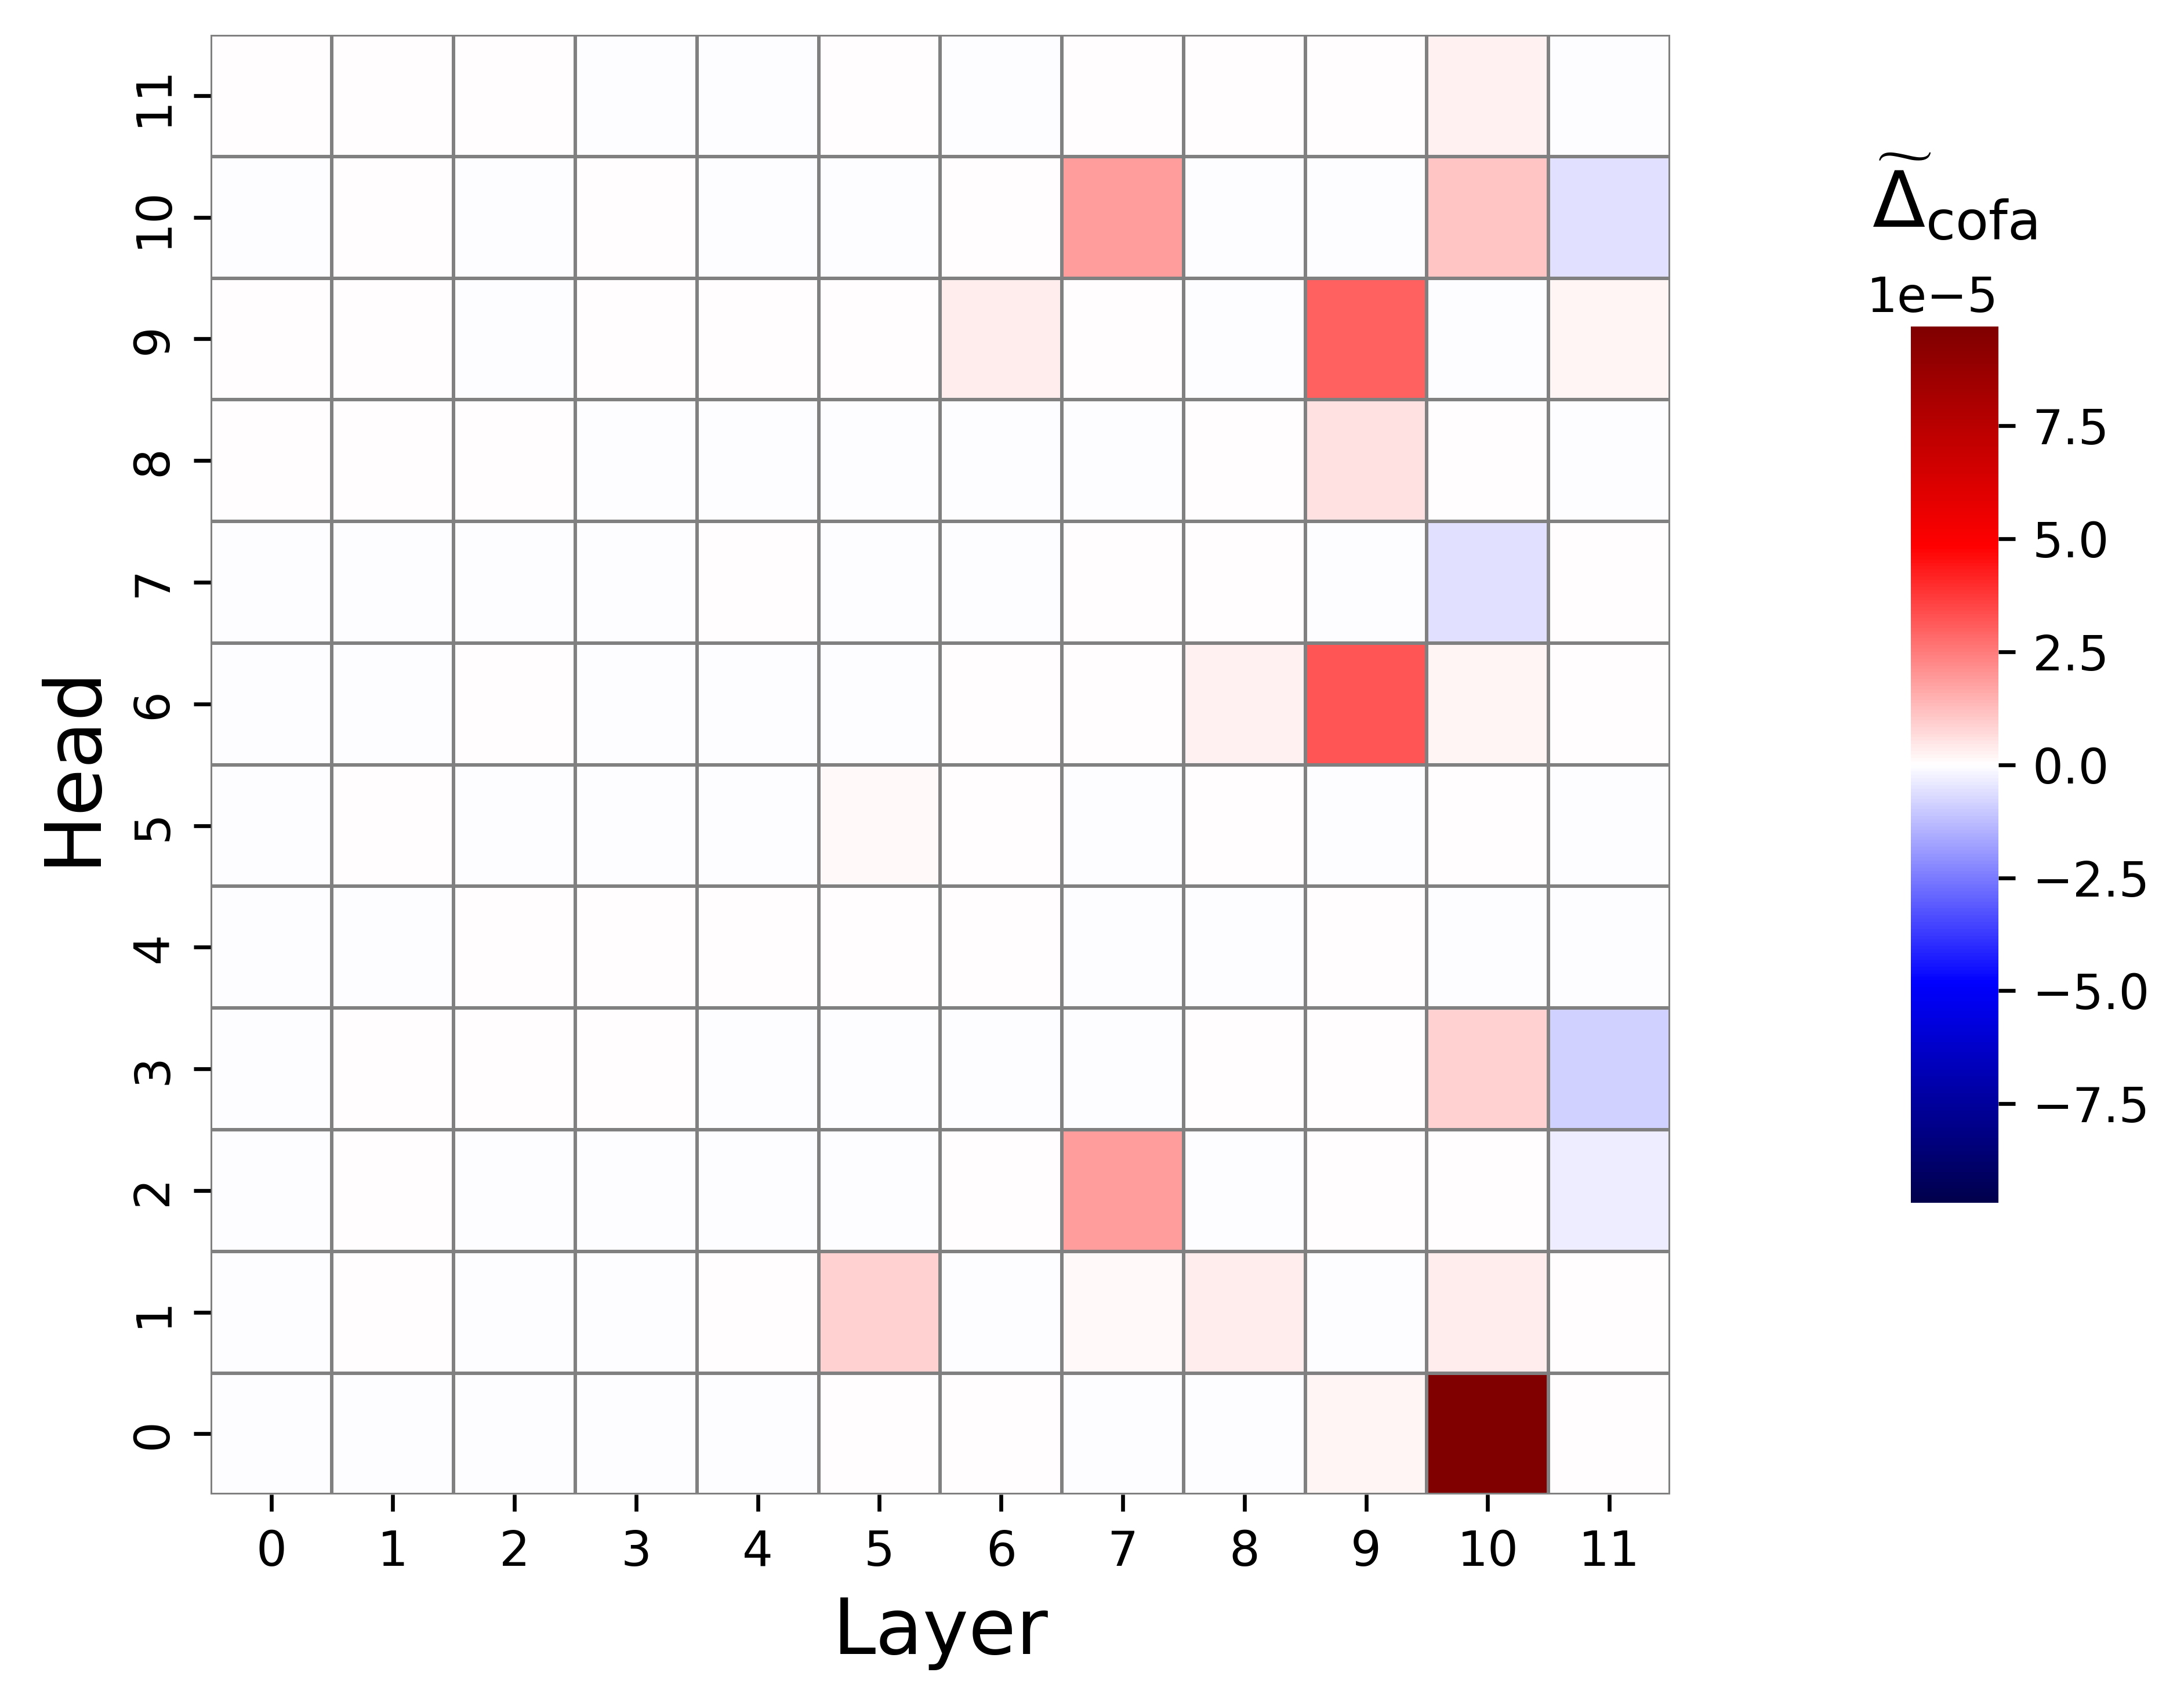

In [34]:
plot_head_attribution_logits_softmax(logit_attribution_data_softmax)

# Attention modification

In [35]:
import itertools
from Src.model import ModelFactory
from Src.dataset import BaseDataset
from Src.experiment import Ablator

sys.path.append('./src')
sys.path.append('.gitignore/data')

if CREATE_CSVS:
  model = ModelFactory.create("gpt2")
  dataset = BaseDataset(path = "data/full_data_sampled_gpt2.json",
                      model = model,
                      experiment="copyVSfact",
                      no_subject=True)
  ablator = Ablator(model=model, dataset=dataset, experiment="copyVSfact", batch_size=20)

COFA_HEADS = [(7, 10), (9, 9), (9, 6), (10, 0)]
FA_HEADS = [(10, 7), (11, 10), (11, 3)]

FA_ALPHAS = [1, 2, 5, 10, 100]
COFA_ALPHAS = [1, 0.5, 0.2, 0.1, 0]


FA_ALPHAS = [1]
COFA_ALPHAS = [1]

# computed results
BEST_BOOST = [((10, 7), (11, 10))]
BEST_SURPRESS = [((7, 10), (9, 9), (9, 6), (10, 0)), ((7, 10), (9, 9), (10, 0)), ((9, 9), (9, 6), (10, 0))]

def one_run_df(ablator, alpha, name_of_experiment):
    cur_df = ablator.run()
    cur_df['alpha'] = alpha
    cur_df['experiment'] = name_of_experiment
    return cur_df

def subset_attn_modif(ablator, heads, name_of_experiment, alpha=0):
    result = []
    for subset_size in range(1, len(heads)+1):
        for heads_subset in itertools.combinations(heads, subset_size):
            ablator.set_heads(heads=list(heads_subset), value=alpha, position='attribute')
            cur_df = one_run_df(ablator, alpha, name_of_experiment)
            cur_df['heads'] = str(heads_subset)
            result.append(cur_df)
    return pd.concat(result)


def gridsearch_attn_modif(ablator, heads, alphas, name_of_experiment):
    result = []
    for alpha in alphas:
        ablator.set_heads(heads=heads, value=alpha, position='attribute')
        cur_df = one_run_df(ablator, alpha, name_of_experiment)
        cur_df['heads'] = str(heads)
        result.append(cur_df)
    return pd.concat(result)


def combination_attn_modif(ablator, heads_boost, heads_surpress, name_of_experiment, alpha_boost=5, alpha_surpress=0):
    combined_result = []
    for boost in heads_boost:
        for surpress in heads_surpress:
            ablator.set_heads(heads=list(boost), value=alpha_boost, position='attribute')
            ablator.set_heads(heads=list(surpress), value=alpha_surpress, position='attribute', reset=False)
            cur_df = one_run_df(ablator, alpha_boost, name_of_experiment)
            cur_df['heads_boost'] = str(boost)
            cur_df['heads_surpress'] = str(surpress)
            cur_df['beta'] = alpha_surpress
            combined_result.append(cur_df)

    return pd.concat(combined_result)



def run_attn_modif():
    fa_results_grid = gridsearch_attn_modif(ablator, FA_HEADS, FA_ALPHAS, "fa_gridsearch")
    cofa_results_grid = gridsearch_attn_modif(ablator, COFA_HEADS, COFA_ALPHAS, "cofa_gridsearch")

    results_grid = pd.concat([fa_results_grid, cofa_results_grid])
    results_grid.to_csv("results_grid.csv", index=False)
    print('Grid search done and saved')

    fa_results_subset = subset_attn_modif(ablator, FA_HEADS, "fa_subset_boost", alpha=5)
    cofa_results_subset = subset_attn_modif(ablator, COFA_HEADS, "cofa_subset_ablate")

    results_subset = pd.concat([fa_results_subset, cofa_results_subset])
    results_subset.to_csv("results_subset.csv", index=False)
    print('Subset search done and saved')

    combined_results = combination_attn_modif(ablator, BEST_BOOST, BEST_SURPRESS, "combined", alpha_boost=5, alpha_surpress=0)
    combined_results.to_csv("results_combined.csv", index=False)
    print('Combined search done and saved')

    all_results = pd.concat([results_grid, results_subset, combined_results])
    all_results.to_csv("all_results.csv", index=False)
    print('All done and saved')


def single_boost(ablator, num, alpha=5, pos="attribute"):
    results = []
    tried_heads = []
    while len(tried_heads) < num:
        heads = np.random.randint(0, 12), np.random.randint(0, 12)
        if heads not in tried_heads:
            tried_heads.append(heads)
            ablator.set_heads([heads], position=pos, value=alpha, reset=True)
            df = ablator.run()
            df['heads'] = str(heads)
            df['experiment'] = 'single_boost'
            df['pos'] = pos
            results.append(df)

    results = pd.concat(results)
    results.to_csv(f"single_boost_{pos}.csv", index=False)

def double_boost(ablator, num, alpha=5, pos="attribute"):
    results2 = []
    tried_tuples = []

    while len(tried_tuples) < num:
        head1, head2 = sorted(((np.random.randint(0, 12), np.random.randint(0, 12)) for _ in range(2)))
        print(head1, head2)
        if (head1, head2) not in tried_tuples:
            tried_tuples.append((head1, head2))
            ablator.set_heads([head1, head2], position=pos, value=alpha, reset=True)
            df = ablator.run()
            df['heads'] = f'{head1}, {head2}'
            df['experiment'] = 'double_boost'
            df['layer_diff'] = abs(head1[0] - head2[0])
            df['pos'] = pos
            results2.append(df)

    results2 = pd.concat(results2)
    results2.to_csv(f"double_boost_{pos}.csv", index=False)

def random_modif():
    np.random.seed(347)

    single_boost(ablator, 50, 5, "all")
    print('Single boost for all done and saved')
    double_boost(ablator, 50, 5, "all")
    print('Double boost for all done and saved')

    single_boost(ablator, 50, 5, "attribute")
    print('Single boost for attribute done and saved')
    double_boost(ablator, 50, 5, "attribute")
    print('Double boost for attribute done and saved')

In [36]:
if CREATE_CSVS:
  run_attn_modif()

In [37]:
if CREATE_CSVS:
  random_modif()

In [38]:
def single_random_recall_by_layer(pos):
    single_boost = pd.read_csv(f"single_boost_{pos}.csv")
    single_boost['heads'] = single_boost['heads'].apply(lambda x: eval(x))
    single_boost['fact_recall'] = single_boost['mem_win'] / 100
    by_layers = [single_boost[single_boost['heads'].apply(lambda x: x[0] == i)].describe()['fact_recall'] for i in range(12)]

    by_layers = pd.concat(by_layers, axis=1).T
    by_layers['layer'] = range(12)
    by_layers.set_index('layer', inplace=True)
    return by_layers


def plot_boxplots():
    single_boost_all = pd.read_csv("single_boost_all.csv")
    single_boost_all['heads'] = single_boost_all['heads'].apply(lambda x: eval(x))
    single_boost_all['fact_recall'] = single_boost_all['mem_win'] / 100
    
    single_boost_attribute = pd.read_csv("single_boost_attribute.csv")
    single_boost_attribute['heads'] = single_boost_attribute['heads'].apply(lambda x: eval(x))
    single_boost_attribute['fact_recall'] = single_boost_attribute['mem_win'] / 100

    by_layers_all = [single_boost_all[single_boost_all['heads'].apply(lambda x: x[0] == i)] for i in range(12)]
    by_layers_attribute = [single_boost_attribute[single_boost_attribute['heads'].apply(lambda x: x[0] == i)] for i in range(12)]

    fig, ax = plt.subplots(1,2, figsize=(6, 3.5), sharey=True)
    ax[0].set_ylim(2, 9)

    ax[0].boxplot([df['fact_recall'] for df in by_layers_all], showfliers=False)

    ax[0].axhline(4.13, color='red', linestyle='--', alpha=0.3)
    ax[0].set_title('All positions altered')

    ax[1].boxplot([df['fact_recall'] for df in by_layers_attribute], showfliers=False)
    ax[1].axhline(4.13, color='red', linestyle='--', alpha=0.3)
    ax[1].set_title('Attribute position altered')

    fig.supylabel('Factual Recall %')
    fig.suptitle('Factual Recall by Layer')
    fig.tight_layout()

    plt.savefig('layer_recall.pdf')

def double_random_recall_analyse(pos):
    double_boost = pd.read_csv(f"double_boost_{pos}.csv")
    double_boost['heads'] = double_boost['heads'].apply(lambda x: eval(x))
    double_boost['fact_recall'] = double_boost['mem_win'] / 100

    same_layer = double_boost[double_boost['heads'].apply(lambda x: x[0][0] == x[1][0])]
    one_layer_apart = double_boost[double_boost['heads'].apply(lambda x: abs(x[0][0] - x[1][0]) == 1)]
    med_far_away = double_boost[double_boost['heads'].apply(lambda x: 1 < abs(x[0][0] - x[1][0]) < 5)]
    far_away = double_boost[double_boost['heads'].apply(lambda x: abs(x[0][0] - x[1][0]) > 5)]

    double_stats = pd.DataFrame(([same_layer.describe()['fact_recall'], one_layer_apart.describe()['fact_recall'], med_far_away.describe()['fact_recall'], far_away.describe()['fact_recall']]))
    double_stats.index = np.array(['same_layer', 'one_layer_apart', 'med_far_away', 'far_away'])
    return double_stats

,count,mean,std,min,25%,50%,75%,max
layer,,,,,,,,
0,8.0,4.186250,0.122817,4.07,4.0900,4.130,4.2900,4.40
1,8.0,4.628750,0.675097,4.05,4.2300,4.335,4.8500,5.69
2,9.0,4.201111,0.299768,3.80,4.0400,4.230,4.3900,4.73
3,12.0,4.244167,0.194584,4.04,4.1325,4.150,4.3275,4.61
4,9.0,4.246667,0.144655,3.97,4.1300,4.300,4.3500,4.43
5,3.0,4.406667,0.332616,4.03,4.2800,4.530,4.5950,4.66
6,7.0,5.397143,1.749340,4.08,4.2650,4.460,6.3900,7.93
7,8.0,4.317500,0.609209,3.07,4.2050,4.355,4.5275,5.25
8,10.0,3.842000,0.575843,2.77,3.9800,4.050,4.1575,4.29


,count,mean,std,min,25%,50%,75%,max
layer,,,,,,,,
0,8.0,4.140000,0.027255,4.12,4.1200,4.130,4.1500,4.20
1,3.0,4.130000,0.000000,4.13,4.1300,4.130,4.1300,4.13
2,7.0,4.130000,0.023094,4.11,4.1200,4.120,4.1300,4.18
3,6.0,4.123333,0.008165,4.11,4.1200,4.125,4.1300,4.13
4,8.0,4.135000,0.010690,4.12,4.1300,4.130,4.1425,4.15
5,7.0,4.038571,0.107460,3.83,4.0000,4.070,4.1200,4.13
6,9.0,4.771111,1.883291,2.49,4.0100,4.120,4.1800,7.96
7,5.0,3.694000,0.691216,2.94,2.9400,4.140,4.1500,4.30
8,7.0,6.565714,4.372177,3.68,3.9850,4.160,8.5950,12.96


,count,mean,std,min,25%,50%,75%,max
same_layer,6.0,4.180000,0.842045,3.15,3.625,4.240,4.4275,5.54
one_layer_apart,20.0,4.054000,0.401791,3.22,3.895,4.055,4.2825,4.84
med_far_away,30.0,4.923000,1.369118,3.32,4.175,4.495,5.2325,9.25
far_away,29.0,4.702069,1.264929,2.84,4.090,4.410,4.7300,8.24


,count,mean,std,min,25%,50%,75%,max
same_layer,23.0,3.932609,0.435193,2.81,3.9250,4.120,4.1450,4.56
one_layer_apart,28.0,4.091786,2.021498,0.56,3.9500,4.115,4.1525,12.98
med_far_away,20.0,4.057000,0.451711,2.93,3.9200,4.115,4.1500,5.24
far_away,28.0,3.633214,1.221599,0.21,2.8125,4.010,4.1600,6.71


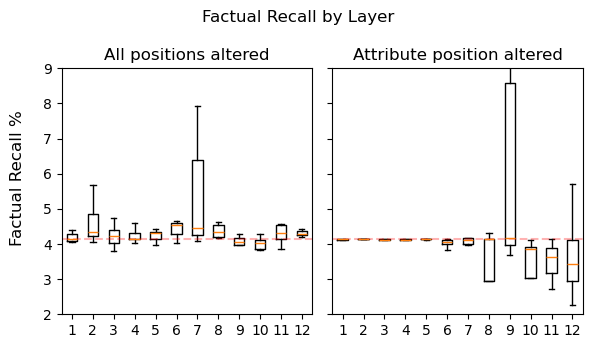

In [39]:
display(single_random_recall_by_layer('all'))
display(single_random_recall_by_layer('attribute'))
display(double_random_recall_analyse('all'))
display(double_random_recall_analyse('attribute'))
plot_boxplots()

# Perplexity calculations

In [40]:
from notebooks.perplexity import run as run_perplexity

if os.getcwd().split(os.sep)[-1] != "notebooks":
  os.chdir("notebooks")

if CREATE_CSVS:
  df = run_perplexity(model="gpt2")
  df.to_csv("../results/modification_perplexity.csv", index=False)
else:
  df = pd.read_csv("../results/modification_perplexity.csv")

display(df)

os.chdir("..")


,experiment,boosted_heads,suppressed_heads,perplexity
0,no_modification,[],[],25.750181
1,best_suppression,[],"[(7, 10), (9, 9), (9, 6), (10, 0)]",25.750181
2,best_boost,"[(10, 7), (11, 10)]",[],25.750181
3,best_combined,"[(10, 7), (11, 10)]","[(7, 10), (9, 9), (9, 6), (10, 0)]",25.750181
